# Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση. 
## Σύστημα συστάσεων βασισμένο στο περιεχόμενο
## Σημασιολογική απεικόνιση δεδομένων με χρήση SOM 
Ημερομηνία εκφώνησης της άσκησης: 29 Νοεμβρίου 2022



Neural Networks - Team 22\
\
Alexandros Tsafos el18211\
Christina Kostaki el18136\
Sofia Vouzika el18843

In [2]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade nltk
!pip install --upgrade scikit-learn
!pip install --upgrade joblib
!pip install --upgrade threadpoolctl
!pip install --upgrade tabulate

## Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με 22.301 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset στο dataframe `df_data_1`: 

In [8]:
import pandas as pd

dataset_url = "https://drive.google.com/uc?export=download&id=1zo13kUAf-MDMPZmBDxq1FxWtZY01lsxD"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3)

Κάθε ομάδα θα δουλέψει σε **ένα μοναδικό υποσύνολο 5.000 ταινιών** (διαφορετικό dataset για κάθε ομάδα) ανάλογα με τον αιρθμό της (Team 22).

In [9]:
import numpy as np

# Στο επόμενη γραμή βάλτε τον αριθμό της ομάδας στο εργαστήριο των νευρωνικών
team_seed_number = 22

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1g6F4TCHrs2wgtdOk7D3gtONaeirNt_Vo"
df_data_2 = pd.read_csv(movie_seeds_url, header=None)

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries
corpus_df = pd.DataFrame(corpus) # dataframe version of corpus

titles = list(map(lambda x : x[0], titles))
categories = list(map(lambda x : x[0], categories))

- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- το dataframe **corpus_df** που είναι απλά το corpus σε μορφή dataframe. Τα summaries βρίσκονται στην κολόνα 0. Πιθανώς να σας βολεύει να κάνετε κάποιες προεπεξεργασίες με dataframes.


Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με `ID=999` (την χιλιοστή) θα γράψουμε `print(corpus[999])`.

In [10]:
ID = 22
print(len(titles))
print(titles[ID])
print(categories[ID])
print(catbins[ID])
print(corpus[ID])

5000
Tanga
"Comedy"
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="70%">

Η πρώτη εφαρμογή που θα αναπτύξουμε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξουμε βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). 


## Προεπεξεργασία

Το πρώτο βήμα στην επεξεργασία των δεδομένων μας είναι ο καθαρισμός των περιγραφών των ταινιών. Για απαλειφή περιττών χαρακτήρων από τις περιγραφές των ταινιών και κατ' επέκταση μείωση του run time χωρίς αλλοίωση της σημασίας των κειμένων, προχωρήσαμε στις παρακάτω αλλαγές:

- Μετατροπή όλων των χαρακτήρων σε πεζούς.
- Απαλειφή σημείων στίξης.
- Αφαίρεση Stopwords. Συγκεκριμένα, πέραν των stopwords της nltk, προσθέσαμε ως extras συχνά εμφανιζόμενες λέξεις μηδενικής προστιθέμενης αξίας στο         περιεχόμενο των περιγραφών.
- Lemmatization. Μετατροπή παράγωγων λέξεων στη λέξη-ρίζα.

Προτιμήσαμε Lemmatization έναντι Stemming, γιατί στη πρώτη περίπτωση μειώνονται μεν κατά λιγότερο οι χαρακτήρες αλλά διατηρείται η εννοιολογική σημασία του κειμένου, ενώ στη δεύτερη τεχνική αποκόπτωνται απλώς οι καταλήξεις, γεγονός που μπορεί να οδηγήσει σε νέους όρους, εντελώς διαφορετικούς από τους προηγούμενους.
Οι παραπάνω μέθοδοι preprocessing υλοποιούνται μία - μία  στα επόμενα κελιά κώδικα.

### Μετατροπή όλων των χαρακτήρων σε πεζούς

In [11]:
# Convert the strings to lowercase using the map() function and the lower() method
lowercase_corpus = list(map(lambda x: x.lower(), corpus))

# Print an example
print(lowercase_corpus[200])

 the first part is a bitter, tragicomic story of dzidziuś, a street-wise bon-vivant, drunkard, and coward who unwillingly becomes a soldier in the home army during the warsaw uprising. dzidziuś wife zosia is having an affair with a hungarian officer stationed nearby, and dzidziuś is ordered to contact the hungarian unit and convince the officer to join the battle against the nazis.  the second novel is set in a pow camp for polish soldiers. lt. zawistowski, one of the interned soldiers, decides to make an attempt to escape from the camp. while none of his fellow inmates are sure whether he succeeded, his absence upsets the guards and provides hope and inspiration for the rest of prisoners. soon his legend grows, making him a hero within the camp and helping to boost the prisoners' morale. however, it turns out that lt. zawistowski didn't actually follow through on his escape plans, but is hiding in the attic of one of the barracks. it turns out that he was hiding from his colleagues, w

### Αφαίρεση Σημείων Στίξης

In [12]:
import re

# Define a function that takes the corpus array and removes punctuation
def remove_punctuation(description):
    # Use a regular expression to remove punctuation
    return re.sub(r'[^\w\s]', '', description)

# Apply the function to each string in the array using the map() function
punct_corpus = list(map(remove_punctuation, lowercase_corpus))

# Print an example
print(punct_corpus[200])

 the first part is a bitter tragicomic story of dzidziuś a streetwise bonvivant drunkard and coward who unwillingly becomes a soldier in the home army during the warsaw uprising dzidziuś wife zosia is having an affair with a hungarian officer stationed nearby and dzidziuś is ordered to contact the hungarian unit and convince the officer to join the battle against the nazis  the second novel is set in a pow camp for polish soldiers lt zawistowski one of the interned soldiers decides to make an attempt to escape from the camp while none of his fellow inmates are sure whether he succeeded his absence upsets the guards and provides hope and inspiration for the rest of prisoners soon his legend grows making him a hero within the camp and helping to boost the prisoners morale however it turns out that lt zawistowski didnt actually follow through on his escape plans but is hiding in the attic of one of the barracks it turns out that he was hiding from his colleagues whose ostentatious patriot

### Αφαίρεση Stopwords και Lemmatization

In [13]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
  

# stopwords from NLTK
my_stopwords = stopwords.words('english')
# my new custom stopwords
my_extra = ['didnt', 'within', 'none', 'however','make', 
           'makes', 'like','well','also', 'get', 'gets', 'take',
          'takes', 'due', 'later', 'isnt', 'cant', 'dont', 'doesnt',
           'wasnt', 'werent', 'arent', 'shouldnt', 'couldnt', 'wouldnt', 
           'would', 'should', 'wants', 'seen', 'much', 'more', 'he', 'she']
# add the new custom stopwrds to my stopwords
my_stopwords.extend(my_extra)

def remove_stopwords(desc):
    text_tokens = desc.split()
    words = [word for word in text_tokens if (word not in my_stopwords) and (len(word) > 2)]
    return ' '.join(words)

def lem_desc(desc):
    text_tokens = desc.split()
    wordnet_lemmatizer = WordNetLemmatizer()
    words = [wordnet_lemmatizer.lemmatize(word) for word in text_tokens]
    
    return " ".join(words)

#Before Lemmatization
pre_lem_corpus = list(map(remove_stopwords, punct_corpus))
#After Lemmatization
final_corpus = list(map(lem_desc, pre_lem_corpus))


[nltk_data] Downloading package stopwords to /Users/alex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/alex/nltk_data...


In [14]:
print(final_corpus[200])

first part bitter tragicomic story dzidziuś streetwise bonvivant drunkard coward unwillingly becomes soldier home army warsaw uprising dzidziuś wife zosia affair hungarian officer stationed nearby dzidziuś ordered contact hungarian unit convince officer join battle nazi second novel set pow camp polish soldier zawistowski one interned soldier decides attempt escape camp fellow inmate sure whether succeeded absence upset guard provides hope inspiration rest prisoner soon legend grows making hero camp helping boost prisoner morale turn zawistowski actually follow escape plan hiding attic one barrack turn hiding colleague whose ostentatious patriotism simply could stand


## Μετατροπή του corpus σε TFIDF



In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
# create sparse tf_idf representation
vectorizer = TfidfVectorizer(use_idf=True)
tf_idf_matrix = vectorizer.fit_transform(final_corpus)
print(tf_idf_matrix.shape)


(5000, 51217)


Η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται εδώ **δεν είναι βελτιστοποιημένη**. Οι επιλογές των μεθόδων και παραμέτρων της μπορεί να έχουν **δραματική επίδραση στην ποιότητα των συστάσεων**, όπως φαίνεται στη συνέχεια. 

## Υλοποίηση του συστήματος συστάσεων

Το σύστημα συστάσεων που θα υλοποιήσουμε θα είναι μια συνάρτηση `content_recommender` με τρία ορίσματα: `target_movie`, `max_recommendations` και `corpus_type`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.
Υλοποιούμε τη συνάρτηση ως εξής: 
- για την ταινία-στόχο, υπολογίζεται η [ομοιότητα συνημιτόνου](https://en.wikipedia.org/wiki/Cosine_similarity) της με όλες τις ταινίες της συλλογής μας όπως αυτές αναπαριστώνται στο `corpus_type`.
- με βάση την ομοιότητα συνημιτόνου που υπολογίστηκε, δημιουργούμε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (`ID`) των ταινιών. Παράδειγμα: αν η ταινία με index 1 έχει ομοιότητα συνημιτόνου με 3 ταινίες \[0.2 1 0.6\] (έχει ομοιότητα 1 με τον εαύτό της) ο ταξινομημένος αυτός πίνακας indices θα είναι \[1 2 0\].
- Για την ταινία-στόχο εκτυπώνουμε: id, τίτλο, σύνοψη, κατηγορίες (categories)
- Για τις `max_recommendations` ταινίες (πλην της ίδιας της ταινίας-στόχου που έχει cosine similarity 1 με τον εαυτό της) με τη μεγαλύτερη ομοιότητα συνημιτόνου (σε φθίνουσα σειρά), εκτυπώνουμε σειρά σύστασης (1 πιο κοντινή, 2 η δεύτερη πιο κοντινή κλπ), ομοιότητα συνημιτόνου, id, τίτλο, σύνοψη, και κατηγορίες (categories)


In [16]:
import numpy as np
from IPython.display import Markdown, display
from sklearn.metrics.pairwise import cosine_similarity


def content_recommender(target_movie, max_recommendations, corpus_type):
    sim = cosine_similarity(corpus_type)
    negatives = list(map(lambda x: -x, sim))
    ix = np.argsort(negatives[target_movie])[:max_recommendations+1]

    recommendations = [{'Similarity':sim[ID][target_movie], 'ID':ID, 'Title':titles[ID], 'Description':corpus[ID][:500]+'...', 'Categories':categories[ID]} for ID in ix]
    df = pd.DataFrame(recommendations)
    movie = recommendations[0]
    print(f'ID: {movie["ID"]} \nTitle: {movie["Title"]} \nDescription: {movie["Description"]} \nCategories: {movie["Categories"]}')
    display(Markdown(df.iloc[1:].to_markdown()))

In [18]:
content_recommender(567, 3, tf_idf_matrix)

ID: 567 
Title: 500 Miles North 
Description: James and John are estranged brothers. But that is changed when they reunite to satisfy their father's last wishes.... 
Categories: "Drama"


|    |   Similarity |   ID | Title                  | Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | Categories                                                                             |
|---:|-------------:|-----:|:-----------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:---------------------------------------------------------------------------------------|
|  1 |     0.303652 | 4517 | Aalkkoottathil Thaniye | Rajan is forced by the death of his father, a schoolteacher, to reunite with his estranged brother and cousin, Ammukutty....                                                                                                                                                                                                                                                                                                                                                                                            | "Drama"                                                                                |
|  2 |     0.21317  | 3737 | Lennon Naked           | In 1964, in the peak of Beatlemania, a reluctant John Lennon  is persuaded by manager Brian Epstein  to meet Freddie Lennon , the father who abandoned him seventeen years earlier, with the press in attendance. When they meet, John accuses his father of abandoning him, but his father says that "he left it up to John." John and Brian quickly leave the meeting. The movie then jumps to 1967, after Brian Epstein has died. The Beatles are giving a press conference about their new film, Magical Myster...  | "Biographical film"                                                                    |
|  3 |     0.179481 | 1858 | Krippendorf's Tribe    | Respected anthropologist James Krippendorf  and his wife, Jennifer ([[Barbara Williams , bring their three children along during their much-enjoyed search in New Guinea for a lost tribe. The search fails, despite the family's best efforts. After Jennifer's death back in the U.S., James falls into academic stagnation, having spent all his foundation grant money raising the children as a single parent. Scheduled to lecture at a college and fearful of being charged with misuse of grant funds, James... | "Comedy of Errors",  "Family Film",  "Screwball comedy",  "Comedy",  "Film adaptation" |

In [19]:
content_recommender(459, 3, tf_idf_matrix)

ID: 459 
Title: Tom and Jerry: Shiver Me Whiskers 
Description: The movie opens above the high seas with a lightning storm is brewing and raging. A group of jolly pirates are sailing on their ship, and all of them are scared of the storm. Meanwhile, a brave captain warns his pirates to lower the sails. After that, the movie continues with Tom and Jerry travel aboard a pirate ship whose captain, Red Pirate Ron, is searching for the "Lost Treasure of the Spanish Mane." By chance, a wave carries the map to the treasure aboard. Tom hides the map, but is warned b... 
Categories: "Family Film",  "Animation"


|    |   Similarity |   ID | Title                   | Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | Categories                         |
|---:|-------------:|-----:|:------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------------------------------|
|  1 |     0.575164 | 1365 | Cruise Cat              | Tom is a mascot aboard a cruise ship and is warned by the captain that Tom will be replaced if a mouse is found on board the ship. Jerry tries to board the ship but is kicked out by Tom, Jerry continues to board the ship unsuccessfully until boarding on the anchor of the ship. He then ties Tom's tail to a lifesaver ring and makes a fake call for help. Tom throws the ring and this results himself being thrown off the ship. Tom manages to get back on the ship anyhow, soaking wet and furious. Jerry... | "Comedy",  "Children's/Family"     |
|  2 |     0.482673 | 4204 | The KarateGuard         | The cartoon starting scene starts outside of the house and then goes to Tom, who was taking a nap but was woken up by Jerry. Tom peeks through the mouse hole to see what the noise was and sees Jerry smacking a punching bag that looks like a cat. After Jerry finishes with the punching bag, his spiritual mentor appears and asks him if he's ready to take on the cat, which is Tom. Jerry nods yes. After Jerry walks out of his mouse hole he sees Tom at the end of a hallway and becomes afraid of him, ...  | "Family Film",  "Animated cartoon" |
|  3 |     0.470238 | 2082 | The Yankee Doodle Mouse | Tom pursues Jerry through a cellar, but the mouse successfully dives into his mousehole . Tom peers into the hole, and Jerry launches a tomato from a mousetrap into his face. Jerry then climbs up the wall and grabs a handful of eggs from a carton marked "Hen-Grenades". As Tom wipes the tomato off his face, he is promptly covered in egg, with one hit to the eye leaving the effect of him wearing a monocle. Jerry shoots off the corks from a champagne case, knocking the cat into a tub of water with...  | "Comedy"                           |

In [20]:
content_recommender(1233, 3, tf_idf_matrix)

ID: 1233 
Title: Absolute Evil 
Description: Lovers Savannah  and Cooper  share a childhood trauma. But just as they seem to have conquered their inner demons, the past catches up on them, and they are soon pursued by enigmatic gang leader Raf  and his plans of retaliation and murder.... 
Categories: "Thriller",  "Mystery",  "Drama",  "Indie",  "Crime Thriller"


|    |   Similarity |   ID | Title                        | Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | Categories                                                                                                       |
|---:|-------------:|-----:|:-----------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------------------------------------------------------------------------------------------------------------|
|  1 |     0.145668 |  163 | Tell Them Willie Boy Is Here | The film's story revolves around the Paiute Indian outlaw Willie Boy ([[Robert Blake  who escapes with his lover, Lola  after killing her father in self defense. According to tribal custom Willie can then claim Lola as his wife. According to the law, Deputy Sheriff Cooper  is required to charge him with murder. Willie Boy and Lola are hunted for several days by a posse led by Cooper. Willie manages to repel the posse’s advance when he ambushes them from the top of Ruby Mountain. He only tries to... | "Action/Adventure",  "Western",  "Drama",  "Indian Western",  "Chase Movie"                                      |
|  2 |     0.133312 | 4879 | Twilight of the Dark Master  | Long ago, the Great Mother Spirit created demons, guardians, and humans. During 2089, only a few demons and guardians remain and in the city of Neo-Shinjuku,.The guardian Tsunami Shijo an ancient fire manipulator from days long ago to aid a fledgling human race. Tsunami is looking for a human who was transformed into a monster by drugs. This leads him to Mr. Takaiya, the Demon leader, who killed his lover. Tsunami becomes involved with a woman who just lost her fiancé and her arm, and now wants ... | "Science Fiction",  "Japanese Movies",  "World cinema",  "Animation",  "Anime",  "Fantasy",  "Horror",  "Action" |
|  3 |     0.101652 | 3864 | Dr. M                        | In the near future, a deadly epidemic is infecting people throughout West Berlin, leading to people taking their own lives to avoid catching it. All the media reports seem like unusual propaganda. No one knows what to do or how to help, except for one police officer who suspects that the suicides are really caused by a lone madman. His investigations lead him to a beautiful, enigmatic woman and the revelation of a sinister plot to manipulate the population through mass hypnosis....                  | "Crime Fiction",  "Mystery",  "Science Fiction"                                                                  |

## Βελτιστοποίηση του TfidfVectorizer

Αφού υλοποιήσουμε τη συνάρτηση `content_recommender` την χρησιμοποιούμε για να βελτιστοποιήσουμε την `TfidfVectorizer`, τόσο όσον αφορά τη συμασιολογική εγγύτητα των συστάσεων που επιστρέφει ο recommender αλλά και όσον αφορά τη μείωση των διαστάσεων του Vector Space Model, διατηρώντας πάντα μία ισορροπία μεταξύ των δύο ζητουμένων.
Συγκεκριμένα, καταλήξαμε -  έπειτα από πολλές δοκιμές - στα παρακάτω attributes που επιστρέφουν σημαντικά βελτιωμένα recommendations:
- ngram_range: λαμβάνει υπόψιν πέρα από μεμονωμένες, και δυάδες, τριάδες κ.ο.κ. λέξεων
- min_df: αγνοεί πολύ σπάνιες λέξεις, ανάλογα με την τιμή που του δίνουμε
- max_df: αγνοεί πολύ συχνές λέξεις, ανάλογα με την τιμή που του δίνουμε

Τα δύο τελευταία ορίσματα χρησιμοποιήθκαν ώστε να μειώσουμε τη διαστατικότητα του πίνακα κοντά στις 4000-5000 για μεγαλύτερη ευκολία στο train, χωρίς όμως να κινδυνεύσει η ποιότητα των αποτελεσμάτων.

In [17]:
import joblib

opt_vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,2), min_df = 0.005, max_df=0.9)
opt_tf_idf = opt_vectorizer.fit_transform(final_corpus)

print(opt_tf_idf.shape)

(5000, 4129)


## Cherry-picking 
Στα επόμενα παραδείγματα βλέπουμε υψηλό similarity και προτάσεις ταινιών από συναφείς κατηγορίες. Ειδικά στο δεύτερο, παρατηρούμε ότι ακόμα και για μεγάλο πλήθος συστάσεων (m=10), το similarity παραμένει υψηλό και οι ταινίες ταιριάζουν μεταξύ τους. Αυτό οφείλεται στο γεγονός ότι επιλέξαμε να μην παραλείψουμε ονόματα, κάτι που στη προκειμένη περίπτωση αποδείχτηκε καλή επιλογή.

In [24]:
content_recommender(567, 5, opt_tf_idf)

ID: 567 
Title: 500 Miles North 
Description: James and John are estranged brothers. But that is changed when they reunite to satisfy their father's last wishes.... 
Categories: "Drama"


|    |   Similarity |   ID | Title                               | Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | Categories                              |
|---:|-------------:|-----:|:------------------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:----------------------------------------|
|  1 |     0.467581 | 4517 | Aalkkoottathil Thaniye              | Rajan is forced by the death of his father, a schoolteacher, to reunite with his estranged brother and cousin, Ammukutty....                                                                                                                                                                                                                                                                                                                                                                                            | "Drama"                                 |
|  2 |     0.322232 | 1408 | Second Best                         | Graham Holt  is a single man aged 42, who attempts to adopt a 10-year-old boy. Graham is a sub-postmaster in Warwickshire, England. James Lennards  is a disturbed child brought up in care. Graham wants a son, but James doesn't want another father. Graham Holt's emotional development has been smothered by his protective parents. His mother has died and he has to care for his bed-ridden father who has had a stroke. James has been shunted from care home to foster home, causing disruption and being ... | "Drama"                                 |
|  3 |     0.308326 | 3737 | Lennon Naked                        | In 1964, in the peak of Beatlemania, a reluctant John Lennon  is persuaded by manager Brian Epstein  to meet Freddie Lennon , the father who abandoned him seventeen years earlier, with the press in attendance. When they meet, John accuses his father of abandoning him, but his father says that "he left it up to John." John and Brian quickly leave the meeting. The movie then jumps to 1967, after Brian Epstein has died. The Beatles are giving a press conference about their new film, Magical Myster...  | "Biographical film"                     |
|  4 |     0.277926 | 2106 | Sarah, Plain and Tall: Winter's End | Sarah and Jacob Witting are on their farm with their family. Jacob's estranged father John reappears one winter, wanting to make amends with his son....                                                                                                                                                                                                                                                                                                                                                                | "Drama"                                 |
|  5 |     0.275703 | 1986 | Iodine                              | John Clem  heads north to investigate the disappearance of his estranged father. Upon arriving at the family cottage, John runs into Avery , his father’s colleague. John receives no help on his dad’s disappearance, but instead, a new set of eyes in which to view the living world around him. Avery assures John that they had been working on a special project which involved using iodine as a water purification tool, to preserve their natural surroundings. Environmental concerns and future implicati... | "Mystery",  "Science Fiction",  "Drama" |

In [25]:
content_recommender(459, 10, opt_tf_idf)

ID: 459 
Title: Tom and Jerry: Shiver Me Whiskers 
Description: The movie opens above the high seas with a lightning storm is brewing and raging. A group of jolly pirates are sailing on their ship, and all of them are scared of the storm. Meanwhile, a brave captain warns his pirates to lower the sails. After that, the movie continues with Tom and Jerry travel aboard a pirate ship whose captain, Red Pirate Ron, is searching for the "Lost Treasure of the Spanish Mane." By chance, a wave carries the map to the treasure aboard. Tom hides the map, but is warned b... 
Categories: "Family Film",  "Animation"


|    |   Similarity |   ID | Title                               | Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | Categories                                                             |
|---:|-------------:|-----:|:------------------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------------------------------------------------------------------|
|  1 |     0.691759 | 1365 | Cruise Cat                          | Tom is a mascot aboard a cruise ship and is warned by the captain that Tom will be replaced if a mouse is found on board the ship. Jerry tries to board the ship but is kicked out by Tom, Jerry continues to board the ship unsuccessfully until boarding on the anchor of the ship. He then ties Tom's tail to a lifesaver ring and makes a fake call for help. Tom throws the ring and this results himself being thrown off the ship. Tom manages to get back on the ship anyhow, soaking wet and furious. Jerry... | "Comedy",  "Children's/Family"                                         |
|  2 |     0.639577 | 4204 | The KarateGuard                     | The cartoon starting scene starts outside of the house and then goes to Tom, who was taking a nap but was woken up by Jerry. Tom peeks through the mouse hole to see what the noise was and sees Jerry smacking a punching bag that looks like a cat. After Jerry finishes with the punching bag, his spiritual mentor appears and asks him if he's ready to take on the cat, which is Tom. Jerry nods yes. After Jerry walks out of his mouse hole he sees Tom at the end of a hallway and becomes afraid of him, ...  | "Family Film",  "Animated cartoon"                                     |
|  3 |     0.626677 |  585 | Hic-cup Pup                         | Spike is putting his son, Tyke, to bed. When a chirping canary flies by, Spike calmly tells the canary to be quiet. However, Tom and Jerry's usual antics wake Tyke up, and Spike asks Tom "Hey, What's the big idea of waking up my boy?!", but the puppy gets the hiccups. Spike is understandably annoyed by both the noise and hiccups and explains that every time he wakes up disturbed from his nap, he gets the hiccups. Spike threatens Tom, placing responsibility on Tom to keep quiet. Jerry immediatel...  | "Short Film",  "Family Film",  "Comedy",  "Animation"                  |
|  4 |     0.599971 | 3812 | Tom and Jerry in the Hollywood Bowl | Tom enters to the stage to rapturous applause. Tom bows down and starts conducting the cat orchestra to the overture of "Die Fledermaus". Jerry emerges from a mouse hole which has a Hollywood Bowl-like exterior. Jerry rushes to the podium to conduct the orchestra alongside Tom. Tom notices Jerry and attempts to flatten him with his baton, until he sees Jerry continuing to conduct the music, from Tom's baton. Tom stuffs him into his suit and continues to conduct the orchestra, but Jerry pops out...  | "Children's/Family"                                                    |
|  5 |     0.594915 | 1825 | Muscle Beach Tom                    | It is a busy day at Muscle Beach; Jerry sunbathes while several cats are working out with weights. Tom and his girlfriend arrive and Tom dumps their beach equipment on top of Jerry. Jerry crawls out from the pile and moves his beach towel further down the beach, but Tom happens to pick where Jerry is lying to plant his beach umbrella. When Jerry digs himself from out of the sand, ripping his beach towel in the process before lying back down, Tom has started carelessly throwing garbage his way. J... | "Short Film"                                                           |
|  6 |     0.59395  | 1234 | Mouse for Sale                      | Tom is reading the paper but quickly discards it and pretends to be asleep when he sees his owner Joan walk past him. He then sees an ad in the paper that says: BIG MONEY PAID FOR WHITE MICE. There is a mouse in the house, but it's not white. A little paint will fix that, though. Tom paints a steel nut yellow to look like cheese and feeds it to Jerry, then attracts him with a magnet. He paints Jerry white and sells him to the local pet store, receiving $50. He hides his earnings under the rug....   | "Children's/Family"                                                    |
|  7 |     0.5868   | 2082 | The Yankee Doodle Mouse             | Tom pursues Jerry through a cellar, but the mouse successfully dives into his mousehole . Tom peers into the hole, and Jerry launches a tomato from a mousetrap into his face. Jerry then climbs up the wall and grabs a handful of eggs from a carton marked "Hen-Grenades". As Tom wipes the tomato off his face, he is promptly covered in egg, with one hit to the eye leaving the effect of him wearing a monocle. Jerry shoots off the corks from a champagne case, knocking the cat into a tub of water with...  | "Comedy"                                                               |
|  8 |     0.585701 | 1993 | Love Me, Love My Mouse              | Tom is in love with Toodles Galore and flies to her house, carrying Jerry in a ring box. Tom presents Jerry to his love interest. Jerry then pretends to be frightened of Tom and cuddles up to Toodles, who instantly sympathises with him, now taking sides with Jerry, as it was. Jerry then makes efforts to work his way into Tom's mouth, leading to Toodles to come to Jerry's "rescue". Realising Jerry is milking the sympathy for all its worth, Tom grabs the conniving rodent and tries to do away with ... | "Short Film",  "Family Film",  "Comedy",  "Romance Film",  "Animation" |
|  9 |     0.582846 | 3351 | Texas Tom                           | Tom and Jerry are engaged in some Western-flavored cat-and-mouse games  when Tom spots a pretty cowgirl cat. Overcome with lust, Tom dresses up in his best cowboy duds and tries to impress the cowgirl, but Jerry sabotages his efforts. Tom takes out tobacco and rolls it up on a piece of paper, then uses Jerry's tongue to stick it closed, Tom smokes it and breathes out the smoke to spell "Howdy" as The cowgirl is flustered and giggly. At one point he sings a song for her on a guitar but has a reco... | "Western",  "Family Film",  "Animation"                                |
| 10 |     0.564549 | 4959 | Cat Napping                         | Jerry is snoozing in a hammock, until Tom walks out with a drink, a radio, a pillow and a newspaper and tries to sit on it. He spots the mouse and slides Jerry off the hammock and into the water; Jerry shortly wakes up after realising he cannot breathe. In retaliation the mouse flips the hammock over, so Tom falls to the ground and swallows his drink glass. After Jerry sits down to sleep, Tom shakes out the hammock such that Jerry is thrown into the air, but by pure fortune the mouse falls into...  | "Short Film",  "Family Film",  "Comedy",  "Animation"                  |

In [33]:
content_recommender(914, 5, opt_tf_idf)

ID: 914 
Title: Shikari 
Description: Virendra is a business tycoon in Cape Town, South Africa. His sister Rajeshwari, his wife Suman & his mother are his only relatives. Virendra's marital life is in apparent discord, since he has never had any relations with Suman. One day, Virendra gets a rival in business world in form of Mahendra Pratap Singh. Mahendra is an Indian spice tycoon wanting to expand his business in South Africa. Virendra is initially wary of Mahendra's expansion plans, but sees the latter's entry as a tool to expan... 
Categories: "Thriller",  "Gangster Film",  "World cinema",  "Mystery",  "Suspense",  "Crime Thriller",  "Bollywood"


|    |   Similarity |   ID | Title     | Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | Categories                                                                                                                      |
|---:|-------------:|-----:|:----------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:--------------------------------------------------------------------------------------------------------------------------------|
|  1 |     0.247149 | 2717 | Dharmatma | Wealthy, powerful and influential Seth Dharamdas  leads a financially secure life in a palatial bungalow. He is known to come help people who are beyond any hope of assistance, and this leads to him being known as "Dharmatma". But Seth Dharamdas does have a number of skeletons in his closet and a parallel life as a gangster and a matka king. The only person whom he dislikes and fears is his own son Ranbir . After a heated argument over Dharmatma's matka business, Ranbir leaves home for Afghanist... | "Action/Adventure",  "Thriller",  "Bollywood",  "World cinema"                                                                  |
|  2 |     0.237033 | 2621 | Baazigar  | Ajay Sharma , is a man who seeks revenge. His father, Vishwanath Sharma , once owner of a great business empire, was defrauded by Madan Chopra , a trusted employee in Vishwanath's company. The Sharma family is ousted from their own company and loses everything they owned. Soon afterwards, Ajay's father and his young baby sister die due to illness, unable to buy medicine because of their destitute state. His mother  is now suffering from mental illness and memory loss. Driven over the edge, Ajay ... | "Thriller",  "Crime Fiction",  "Melodrama",  "World cinema",  "Musical",  "Drama",  "Suspense",  "Crime Thriller",  "Bollywood" |
|  3 |     0.223524 | 1388 | Lanka     | Lanka is a modern take on the Ramayana with Sita's life being saved by Vibhishan  from Raavan. "Lanka" begins in current day Mumbai with Anju  telling about her past. Jaswant Sisodia  is the don of a small town in UP, India called Bijnor. He rules the place and the police and politicians support him. He is in love with Anju, a doctor. Her father is the Chief Medical Officer of Bijnor. Anju is actually sexually exploited by Sisodia. He every night after taking drinks comes to her house and sleeps... | "Drama"                                                                                                                         |
|  4 |     0.221585 |  641 | Oily Hare | Along Highway $101.00, approximately 531 miles from "Dollar$, Texas" and near "Deepinahearta", Texas, Bugs' rabbit hole in "Deepinahola", Texas upsets an oil tycoon, who sounds and acts like Yosemite Sam, because it isn't producing any oil. The tycoon pulls up to the hole in a green stretch limousine that is so long that it requires a long-distance telephone operator in the middle of the car to connect the tycoon to his chauffeur, Maverick, so he can tell Maverick  to stop the car. The tycoon sa... | "Short Film",  "Family Film",  "Animation"                                                                                      |
|  5 |     0.220105 | 3452 | Bhoot     | The story is about Vishal  who is married to Swati . The couple buy a high rise apartment at a ridiculously low price. The caretaker of the apartment, Mr Thakkar  explains to Vishal that a widow named Manjeet Khosla, the previous resident, committed suicide after killing her own son. Vishal hides this fact from Swati, as she will object to buying such a residence. But Mr.Thakkar accidentally slips in the secret. Swati is livid at Vishal, although he disbelieves the notions of ghosts and bad luck... | "Thriller",  "Horror",  "Bollywood"                                                                                             |

In [38]:
content_recommender(1501, 5, opt_tf_idf)

ID: 1501 
Title: The Seinfeld Chronicles 
Description: The series opens with Jerry Seinfeld and George Costanza seated at Pete's Luncheonette, debating the placement of one of George's shirt buttons. The waitress, Claire, pours each of them a cup of coffee. George frets about whether Claire is giving him regular or decaffeinated coffee, saying he does not want caffeine in it. Claire later, to annoy him, implies that she gave him regular. Jerry then tells George about a woman he met in East Lansing, Michigan, Laura, who is coming to New York. Jerry w... 
Categories: "Short Film",  "Comedy"


|    |   Similarity |   ID | Title                               | Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | Categories                                                                                                                                                                                     |
|---:|-------------:|-----:|:------------------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  1 |     0.454878 | 1993 | Love Me, Love My Mouse              | Tom is in love with Toodles Galore and flies to her house, carrying Jerry in a ring box. Tom presents Jerry to his love interest. Jerry then pretends to be frightened of Tom and cuddles up to Toodles, who instantly sympathises with him, now taking sides with Jerry, as it was. Jerry then makes efforts to work his way into Tom's mouth, leading to Toodles to come to Jerry's "rescue". Realising Jerry is milking the sympathy for all its worth, Tom grabs the conniving rodent and tries to do away with ... | "Short Film",  "Family Film",  "Comedy",  "Romance Film",  "Animation"                                                                                                                         |
|  2 |     0.454194 | 2929 | Twin Peaks: Fire Walk With Me       | The film opens with Gordon Cole  calling Agent Chester Desmond  about the mysterious murder of Teresa Banks in the town of Deer Meadow. Cole introduces Chester to his new partner, Sam Stanley , and they receive clues from Lil the dancer. While Chet explains most of the clues given by the appearance of Lil to Sam, he does not explain the blue rose. After difficulty with the local police force, Desmond and Stanley eventually view Teresa's body at a morgue, realizing that her ring is missing and t...  | "Crime Fiction",  "Thriller",  "Horror",  "Supernatural",  "Surrealism",  "Experimental film",  "Psychological thriller",  "Mystery",  "Drama",  "Suspense",  "Crime Thriller",  "Avant-garde" |
|  3 |     0.447269 | 1915 | Fright Night                        | Charley Brewster  is a teenager living in a suburb of Las Vegas, Nevada, who discovers that a new neighbor has moved in next door to him. Charley's former best friend, "Evil" Ed Lee , informs him that many fellow students have gone missing. When Charley goes home after school, his mother  introduces him to Jerry Dandrige , their new neighbor. Charley becomes fed up with Ed after he claims that Jerry is a vampire. On his way home, Ed is confronted by Jerry, who bites him. The next day, Charley re... | "Remake",  "Comedy horror",  "Vampire movies",  "Horror"                                                                                                                                       |
|  4 |     0.406463 | 3812 | Tom and Jerry in the Hollywood Bowl | Tom enters to the stage to rapturous applause. Tom bows down and starts conducting the cat orchestra to the overture of "Die Fledermaus". Jerry emerges from a mouse hole which has a Hollywood Bowl-like exterior. Jerry rushes to the podium to conduct the orchestra alongside Tom. Tom notices Jerry and attempts to flatten him with his baton, until he sees Jerry continuing to conduct the music, from Tom's baton. Tom stuffs him into his suit and continues to conduct the orchestra, but Jerry pops out...  | "Children's/Family"                                                                                                                                                                            |
|  5 |     0.400859 | 2884 | Fargo                               | In the winter of 1987, Minneapolis automobile salesman Jerry Lundegaard  is in financial trouble. After being introduced to criminals Carl Showalter  and Gaear Grimsrud  by Native American ex-convict Shep Proudfoot , a mechanic at his dealership, Jerry travels to Fargo, North Dakota, and hires the two men to kidnap his wife Jean  in exchange for a new car and half of the $80,000 ransom. However, Jerry intends to demand a much larger sum from his wealthy father-in-law, Wade Gustafson , and keep m... | "Crime Fiction",  "Thriller",  "Indie",  "Drama",  "Comedy",  "Black comedy",  "Neo-noir"                                                                                                      |

In [47]:
content_recommender(1511, 5, opt_tf_idf)

ID: 1511 
Title: Switching Goals 
Description: 12 year old Fraternal twin sisters Sam and Emma Stanton are opposites growing up in Evanston. Sam is a star Soccer player and a Tomboy; however she wants to attract boys. Emma is a Girly girl who enjoys Fashion and Make up, but she wants to be better at sports. Their dad Jerry one of the Soccer coaches is pressured by his wife Denise to pick Emma for the Hurricanes Co-ed team. Just as Jerry is about to pick Sam for his team after Round 2 of Soccer Tryouts is over the Buzzards coach Willard Holme... 
Categories: "Sports",  "Family Film",  "Comedy",  "Children's/Family"


|    |   Similarity |   ID | Title              | Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | Categories                                                                                                                    |
|---:|-------------:|-----:|:-------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:------------------------------------------------------------------------------------------------------------------------------|
|  1 |     0.524984 | 1590 | A Cinderella Story | The setting is a small cottage. The film starts with a ten-year old girl named Sam Montgomery  living in the San Fernando Valley area of Los Angeles, with her widowed father Hal , who runs a popular sports-themed diner. Hal soon marries a vain, self-absorbed woman named Fiona . Hal is killed when, during an earthquake, he runs to save Fiona. Supposedly leaving no will, Fiona receives all of his belongings, including the house and diner, and to her dismay, Sam. Eight years later, eighteen-year ol... | "Romantic comedy",  "Children's",  "Comedy",  "Romance Film",  "Family Film",  "Teen"                                         |
|  2 |     0.484541 | 4201 | Feeling Minnesota  | Freddie  is a former stripper marrying Sam  to repay a debt owed to nightclub owner Red. But Freddie is in love with Jjaks , Sam's brother. Jjaks and Freddie run off together, and Sam finds where they have been hiding and calls the cops. Meanwhile someone calls to blackmail Sam and Jjaks. Sam ends up shooting Freddie in the stomach in Jjak's car, and tries to frame the killing on Jjaks. Sam partially admits his crime to a waiter in the local diner. Jjaks hastily avoids being caught by the police... | "Crime Fiction",  "Road movie",  "Action Comedy",  "Action/Adventure",  "Comedy",  "Black comedy",  "Romance Film",  "Action" |
|  3 |     0.470415 |  918 | Moon               | Sam Bell is nearing the end of a three-year work contract at Lunar Industries' largely automated "Sarang" lunar base, where he is the sole resident. Sam oversees automated harvesters and launches canisters bound for Earth containing the helium-3 they extract. Chronic communication problems limit him to occasional recorded messages with his wife Tess, who was pregnant with their daughter Eve when he left. His only companion is an artificial intelligence assistant named GERTY, who assists with the... | "Thriller",  "Science Fiction",  "Psychological thriller"                                                                     |
|  4 |     0.452447 | 1651 | Josh and S.A.M.    | The film is a road-trip themed dark comedy about two young brothers who run away from home due to emotional conflict over the divorce of their parents. Jacob Tierney plays older brother Josh who unintentionally brainwashes his younger brother Sam  making him believe that he was a genetically designed child warrior. Josh says that Sam is actually an acronym, and that he is a "Strategically Altered Mutant" that was designed by the government to fight in a secret war in Africa. After a series of va... | "Road movie",  "Comedy",  "Coming of age",  "Adventure",  "Children's/Family"                                                 |
|  5 |     0.435837 | 1894 | You're Telling Me! | Sam Bisbee  is an optometrist and an amateur inventor. His daughter Pauline  is in love with Bob Murchison , but Bob's upper-class mother  wants nothing to do with anyone related to uncouth Sam Bisbee. Even Sam's wife Bessie  is ashamed of him, because he prefers to be himself rather than put on airs. Pauline is the one woman who truly loves Sam, accepting her father as he is. Sam receives a letter from the National Tire Company expressing interest in one of his inventions, puncture-proof tires ... | "Comedy",  "Black-and-white",  "Slapstick"                                                                                    |

## Nit-picking 
Ακολουθεί μια περίπτωση που ο recommender μας προτείνει ταινίες όχι τόσο σχετικές με το είδος της ταινίας-στόχου. Αντιλαμβανόμαστε από τα είδη και την περιγραφή ότι δεν έχουν αρκετα κοινά οι προτεινόμενες ταινίες, ωστόσο στην πρώτη πρόταση φαίνεται να έπαιξε ρόλο το - κοινό στις δύο ταινίες - όνομα Cooper.

In [62]:
content_recommender(1233, 3, opt_tf_idf)

ID: 1233 
Title: Absolute Evil 
Description: Lovers Savannah  and Cooper  share a childhood trauma. But just as they seem to have conquered their inner demons, the past catches up on them, and they are soon pursued by enigmatic gang leader Raf  and his plans of retaliation and murder.... 
Categories: "Thriller",  "Mystery",  "Drama",  "Indie",  "Crime Thriller"


|    |   Similarity |   ID | Title                        | Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | Categories                                                                                                       |
|---:|-------------:|-----:|:-----------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------------------------------------------------------------------------------------------------------------|
|  1 |     0.282548 |  163 | Tell Them Willie Boy Is Here | The film's story revolves around the Paiute Indian outlaw Willie Boy ([[Robert Blake  who escapes with his lover, Lola  after killing her father in self defense. According to tribal custom Willie can then claim Lola as his wife. According to the law, Deputy Sheriff Cooper  is required to charge him with murder. Willie Boy and Lola are hunted for several days by a posse led by Cooper. Willie manages to repel the posse’s advance when he ambushes them from the top of Ruby Mountain. He only tries to... | "Action/Adventure",  "Western",  "Drama",  "Indian Western",  "Chase Movie"                                      |
|  2 |     0.229882 | 4879 | Twilight of the Dark Master  | Long ago, the Great Mother Spirit created demons, guardians, and humans. During 2089, only a few demons and guardians remain and in the city of Neo-Shinjuku,.The guardian Tsunami Shijo an ancient fire manipulator from days long ago to aid a fledgling human race. Tsunami is looking for a human who was transformed into a monster by drugs. This leads him to Mr. Takaiya, the Demon leader, who killed his lover. Tsunami becomes involved with a woman who just lost her fiancé and her arm, and now wants ... | "Science Fiction",  "Japanese Movies",  "World cinema",  "Animation",  "Anime",  "Fantasy",  "Horror",  "Action" |
|  3 |     0.183693 | 2546 | Northville Cemetery Massacre | A gang of Detroit bikers are framed for a rape they didn't commit and pursued by a pack of trigger-happy lawmen.DVD Verdict...                                                                                                                                                                                                                                                                                                                                                                                          | "Crime Fiction",  "Action/Adventure",  "Action",  "Drama"                                                        |

Αντίστοιχα, βλέπουμε μία ταινία horror, για την οποία ο recommender βρίσκει παρόμοιες κάποιες κωμωδίες και ρομαντικές ταινίες. Βρίσκει, μάλιστα, και ένα από τα μεγαλύτερα similaritiew που παρατηρήσαμε σε αυτό το corpus. 

In [23]:
content_recommender(4352, 5, opt_tf_idf)

ID: 4352 
Title: The Eye 
Description: Sydney Wells  is a successful classical violinist who has been blind since the age of five. Fifteen years later, Sydney undergoes a cornea transplant, which causes her eyesight to return, a bit blurry at first. As time goes on, Sydney's vision begins to clear; however, she also begins experiencing terrifying visions, mostly of fire and of people dying. The bulk of the rest of the film concerns Sydney unravelling the mystery of the visions, and trying to convince others, primarily her visual ther... 
Categories: "Thriller",  "Drama",  "Horror",  "Psychological thriller",  "Supernatural"


|    |   Similarity |   ID | Title                      | Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | Categories                                                                   |
|---:|-------------:|-----:|:---------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------------------------------------------------------------------------|
|  1 |     0.575975 | 4757 | Sydney White               | Sydney White  is the daughter of a plumber, Paul White ([[John Schneider . Her mother, a Kappa Sorority member, died when Sydney was still young. She sets off to study in a SAU and to pledge to her mother's once dignified sorority, Kappa Phi Nu. There she meets Demetria Rosemead Hotchkiss , known as Dinky, also an upcoming member of the Kappa Sorority as a legacy like her, and becomes her closest girl friend. While on their way to their dorm, she meets Tyler Prince , the president of the fratern... | "Romantic comedy",  "Romance Film",  "Comedy",  "Teen"                       |
|  2 |     0.285243 | 4737 | Fat Pizza: The Movie       | Fat Pizza the film is yet another slice of life at a dodgy suburban Sydney take away. Bobo Gigliotti the psychotic pizzeria owner/pizza chef is awaiting the arrival of his mail-order refugee bride Lin Chow Bang, and a new pizza deliverer is on the block....                                                                                                                                                                                                                                                       | "Comedy"                                                                     |
|  3 |     0.277305 | 2386 | Desperately Seeking Brandi | A teenage girl chronicles her best friend's obsession with American women's soccer star Brandi Chastain and his quest to meet her during the 2000 Sydney Olympics, through a series of comic mishaps and up to, at last, a meeting with Brandi herself....                                                                                                                                                                                                                                                              | "Short Film"                                                                 |
|  4 |     0.274186 | 4867 | The Set                    | Paul Lawrence is a working class man who dates Cara, sells shirts at a Sydney department store, and dreams of attending art school. Cara leaves for London and Paul becomes the protege of designer Marie Rosefield. Through this he enters the "set", the world of Sydney art society. Rosefield is friends with Mark Broniski, an artist who commissions Paul to design a set for British stage director John L Fredericks. Paul is helped by art student Tony Brown, who is dating Paul's cousin, Kim Sylvester. ... | "Drama"                                                                      |
|  5 |     0.264553 | 1447 | Rain                       | A boat, which was en route to Apia, is temporarily stranded on the South Pacific island village of Pago Pago due to a possible cholera outbreak on board. Among the passengers are Alfred Davidson, a self-righteous missionary, his wife, and Sadie Thompson, a prostitute. Thompson passes the time partying and drinking with the American Marines stationed on the island. Sergeant Tim O'Hara, nicknamed by Sadie as "Handsome", falls in love with her.  Her wild behavior soon becomes more than the Davidson... | "Drama",  "Romantic drama",  "Romance Film",  "Pre-Code",  "Black-and-white" |

Εδώ, προτείνονται τανίες τρόμου, μετά την προβολή μιας οικογενειακής ταινίας. Μάλλον ατυχές και εν δυνάμει τραυματικό...

In [37]:
content_recommender(1500, 5, opt_tf_idf)

ID: 1500 
Title: Black Tulip 
Description: The film depicts the fictional Mansouri family who start a restaurant in Kabul named The Poet's Corner, where artists and writers meet.... 
Categories: "Family Film",  "Drama"


|    |   Similarity |   ID | Title                                           | Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | Categories                                                                                                                                  |
|---:|-------------:|-----:|:------------------------------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:--------------------------------------------------------------------------------------------------------------------------------------------|
|  1 |     0.330277 |  409 | Still Waiting...                                | The film describes the misadventures of the staff at the fictional chain restaurant Shenaniganz as they cope with competition from a Hooters-esque restaurant called Ta-Tas Wing Shack....                                                                                                                                                                                                                                                                                                                              | "Workplace Comedy",  "Indie",  "Comedy"                                                                                                     |
|  2 |     0.283288 | 2722 | The Ghost Writer                                | An unnamed British ghostwriter  is recruited to complete the memoirs of former Prime Minister Adam Lang . His predecessor on the project and Lang's long-term aide, Mike McAra, died in an apparent accident. The writer travels to the fictional Massachusetts village of Old Haven on Martha's Vineyard, where Lang is staying with his wife, Ruth , and a staff of servants and security personnel. The writer is checked into a small hotel. Lang's personal assistant , Amelia Bly , forbids him to take McAra'... | "Thriller",  "Crime Fiction",  "Psychological thriller",  "Mystery",  "Drama",  "Political thriller",  "Crime Thriller",  "Political drama" |
|  3 |     0.246618 |  822 | The Sticky Taste of a Peach-Skinned Proprietess | The film depicts the romantic entanglements, past and present, involving a family which owns a noodle shop....                                                                                                                                                                                                                                                                                                                                                                                                          | "Japanese Movies"                                                                                                                           |
|  4 |     0.237822 | 2407 | Possession                                      | The film tells the story of two scholars, Roland Michell  and Maud Bailey , who investigate the affair of fictional Victorian era poet Randolph Henry Ash , described in letters between him and another fictional poet, Christabel LaMotte ....                                                                                                                                                                                                                                                                        | "Thriller",  "Mystery",  "Drama",  "Film adaptation",  "Romantic drama",  "Romance Film"                                                    |
|  5 |     0.232348 |  797 | My Dear Secretary                               | Writer and playboy Owen Waterbury  hires aspiring writer Stephanie 'Steve' Gaylord  as his secretary....                                                                                                                                                                                                                                                                                                                                                                                                                | "Romance Film",  "Drama",  "Comedy",  "Black-and-white"                                                                                     |

In [51]:
content_recommender(1803, 5, opt_tf_idf)

ID: 1803 
Title: Le gendarme et les gendarmettes 
Description: Four young beautiful female police officers come to learn from the "masters" but it turns out they are coping much better with the problem than their teachers. But the things get hotted up when the "gendarmettes" are kidnapped one by one.... 
Categories: "Comedy"


|    |   Similarity |   ID | Title                       | Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | Categories                                                                                                                                  |
|---:|-------------:|-----:|:----------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:--------------------------------------------------------------------------------------------------------------------------------------------|
|  1 |     0.238265 | 1386 | Vedan                       | Ganesh , an honest police officer, appoints Vijay  to stop Boopathy . Vijay begins to work as an infiltrator in Boopathy's gang....                                                                                                                                                                                                                                                                                                                                                                                     | "Crime Fiction"                                                                                                                             |
|  2 |     0.22535  | 4659 | Shinjuku Triad Society      | The film is based around the interactions of a homosexual triad group with a police officer as well as opposing yakuza organizations. When the younger brother to a renegade police officer becomes the lawyer to the triad group, an argument between the two leads to the downfall of the organization....                                                                                                                                                                                                            | "Crime Fiction",  "Thriller",  "Gangster Film",  "World cinema",  "Chase Movie",  "Action/Adventure",  "Crime Thriller",  "Japanese Movies" |
|  3 |     0.222151 |  519 | Christian Brothers          | The film is about Palamattathu Varghese Mappila ([[Saikumar , a wealthy, retired captain of the Indian Army. He has four children, Christy , Joji ([[Dileep , Jessy  and Stella ([[Kanika . Christy is a high profile police informer who is working in Mumbai and getting high amounts as remuneration. His brother Joji goes to Italy to study theology, but later opts out of it after he falls in love with Meenakshi , daughter of the state home minister ([[Devan . His family has no clear idea about the na... | "Thriller",  "Mystery",  "Action",  "Drama"                                                                                                 |
|  4 |     0.219421 | 4592 | Oomappenninu Uriyadappayyan | The plot concerns the love between a poor mute man and a deaf-mute girl who elopes from her family. They face problems from a corrupt police officer who wants to molest the girl....                                                                                                                                                                                                                                                                                                                                   | "Action",  "Drama",  "Comedy"                                                                                                               |
|  5 |     0.212433 | 3477 | Fudoh: The New Generation   | Riki Fudoh's brother was killed by his father at the request of his yakuza organization. Riki does not let his father know that he saw the murder take place but instead starts an organization that takes over his high school. Riki's two personal bodyguards are a gun-toting female student and a hermaphrodite student who wields a dartgun with her vagina. After Riki kills one of his teachers for not paying back a loan, a beautiful female teacher arrives. When the teacher visits Riki at his house, it... | "Thriller",  "Crime Fiction",  "Japanese Movies",  "World cinema",  "Surrealism",  "Action/Adventure",  "Crime Thriller",  "Gangster Film"  |

In [53]:
content_recommender(2720, 5, opt_tf_idf)

ID: 2720 
Title: Granpa 
Description:  The film celebrates the relationship between a small girl, Emily , and her kindly but ailing grandfather . Emily's playful innocence is contrasted with Granpa's increasing frailty. Aware that his days are numbered, he shares his memories of adventures and days gone by. These memories are vividly brought to life by her grandfather's tales, beginning with a description of Granpa's childhood and youth in the early part of the 20th Century. Other adventures include a chivalrous tale of Saint George... 
Categories: "Dance",  "Children's/Family",  "Animation",  "Short Film",  "Children's",  "Family Film"


|    |   Similarity |   ID | Title                      | Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | Categories                                                                             |
|---:|-------------:|-----:|:---------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:---------------------------------------------------------------------------------------|
|  1 |     0.284984 | 3426 | Case 39                    | Social worker Emily Jenkins  is assigned to investigate the family of ten year-old Lillith Sullivan , as her grades have declined and an emotional rift with her parents has emerged. Emily suspects that the parents have been mistreating Lillith. Emily's fears are confirmed when Lillith's parents try to kill her by roasting her in the oven at their home. Emily saves Lillith with the help of Detective Mike Barron . Lillith is originally sent to a children's home, but she begs Emily to look after he... | "Thriller",  "Horror",  "Supernatural",  "Mystery",  "Suspense",  "Crime Thriller"     |
|  2 |     0.215127 | 1302 | A Perfect Murder           | Steven Taylor  is a Wall Street hedge fund manager whose investments and speculations allow him to live an extravagant upper class lifestyle with his much younger wife Emily . Unfortunately for Taylor, his illegal investments are unraveling; to alleviate the pressure being put on him by large upcoming margin payments he will need his wife's personal fortune  to maintain that status and lifestyle. Emily seems a faithful wife, but in reality she is having an affair with a painter, David Shaw  and ... | "Thriller",  "Crime Thriller",  "Suspense"                                             |
|  3 |     0.201422 | 4367 | Falling Sky                | Murphy plays the role of Emily. Her alcoholic mother, Resse, tells her that the disease runs in the family, and she is at risk of having it too. After Resse kills herself in the bathtub, she leaves a recorded tape saying "I'm sorry Emily, but I'm just so tired." Devastated, Emily turns to drink, and the prophecy comes true. However, after seeing what alcohol has done to her life, Emily drives to a lake and tries to drown herself. At the last minute, she gasps for air and says "My mother chose to... | "Family Drama",  "Drama",  "Indie"                                                     |
|  4 |     0.196735 | 4629 | The Exorcism of Emily Rose | Lawyer Erin Bruner defends a priest, Father Richard Moore, who is charged in connection with an exorcism that lead to the death of Emily Rose. The trial begins with the calling of several medical experts by the prosecutor, Ethan Thomas. One expert testifies that Emily was suffering from both epilepsy and psychosis. The defense contests that she may have actually been possessed, though Bruner is careful never to say that in so many words. Indeed, Bruner explains that Emily was suffering from som...  | "Thriller",  "Crime Fiction",  "Horror",  "Supernatural",  "Drama",  "Courtroom Drama" |
|  5 |     0.172333 | 1261 | Fujian Blue                | Fujian Blue takes place in the southeastern coastal province of Fujian . The film follows several characters in two separate but linked tales in the aftermath of the Communist government's decision to open the province up to the outside world in the 1980s. The first tale, entitled "The Neon Knights" follows the youth Amerika  who lives in Fuqing. Amerika works for Roppongi , who operates a blackmailing ring that targets lonely housewives who have committed adultery while their husbands are away.... | "Drama"                                                                                |

## Πλεονεκτήματα - Μειονεκτήματα του tf-idf

Παρατηρούμε ότι ο tfidf recommender υλοποείται γρήγορα, καθώς για τη μέθοδο αυτή χρησιμοποιούνται εύκολα υπολογίσιμες ποσότητες που λειτουργούν ως απλές μετρικές, οι οποίες συσχετίζουν λέξεις ή όρους μεταξύ των περιγραφών. Αλλάζοντας τα διάφορα ορίσματά του πετυχαίνουμε σημαντική βελτίωση σε κάποιες ταινίες-στόχους, αλλά ποτέ συνολικά για όλο το dataset. Όσον αφορά τους πίνακες που δημιουργούνται, επειδή είναι πολύ αραιοί, αυξάνεται δραματικά το μέγεθος του vocabulary και γιαυτό αναγκαζόμαστε να το μειώσουμε κατά πολύ, απορρίπτωντας πιθανώς και χρήσιμο περιεχόμενο. Επιπλέον, δεν λαμβάνει υπόψιν χαρακτηριστικά όπως τη θέση των λέξεων μέσα στο κείμενο ή οποιαδήποτε αλληλεπίδραση μεταξύ τους, περιορίζεται μόνο σε ποσοστά συνολικής τους εμφάνισης. Αυτά θα προσπαθήσουμε να επιλύσουμε με τη μέθοδο W2V.

## Βαθιά μάθηση: δημιουργία corpora με χρήση word emmbeddings

Η προσέγγιση της κατασκευής μόνο μέσω tfidf του συστήματος συστάσεων έχει διάφορα μειονεκτήματα. Θα μας ενδιέφερε λοιπόν να δούμε αν μπορούμε να χρησιμοποιήσουμε για τις λέξεις **εμφυτεύματα (embeddings)**, δηλαδή τις πυκνές διανυσματικές αναπαραστάσεις για τις λέξεις που μας δίνει το μοντέλο **Word2Vec**

Ωστόσο, το dataset των 5000 ταινιών είναι πολύ μικρό για να εξάγουμε τα δικά μας word embeddings (και να είναι καλά). Για το λόγο αυτό θα χρησιμοποιήσουμε τη μεθοδολογία της Βαθιάς Μάθησης που είναι η **Μεταφορά Μάθησης (Transfer Learning).**.

Στη μεταφορά μάθησης ουσιαστικά μεταφέρουμε τη γνώση που έχει αποκτήσει ένα ήδη εκπαιδευμένο (και κατά κανόνα πολύ μεγάλο) σύστημα. Η μεταφορά γίνεται διαμέσου των τιμών των βαρών που έχει προσδιορίσει μετά το πέρας της εκπαίδευσης.

Στην περίπτωσή μας, δεν μας ενδιαφέρουν τόσο τα ίδια τα βάρη των μοντέλων από τα οποία θα κάνουμε μεταφορά μάθησης. Κάτι τέτοιο θα μας ενδιέφερε αν π.χ. θέλαμε να συνεχίσουμε την εκπαίδευση στα δικά μας κείμενα. Μας ενδιαφέρουν όμως τα ίδια τα εμφυτεύματα, δηλαδή τα embeddings (διανύσματα διαστάσεων $m$) που έχει μάθει το νευρωνικό για το λεξιλόγιο του (vocabulary). To vocabulary σε τέτοια μεγάλα νευρωνικά θα είναι πιθανότατα υπερσύνολο του δικού μας.

### Μεταφορά μάθησης εμφυτευμάτων



#### Εμφυτεύματα του Gensim-data
Το Gensim περιλαμβάνει αρκετά προεκπαιδευμένα μοντέλα εμφυτευμάτων Word2Vec. Με το επόμενο κελί παίρνουμε τη λίστα τους.

In [ ]:
!pip install -U gensim

In [56]:
import gensim.downloader as api

print(list(api.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


Τα μοντέλα αυτά βρίσκονται στο [αποθετήριο Gensim-data](https://github.com/RaRe-Technologies/gensim-data). Η φόρτωση των μοντέλων αυτών γίνεται με τη συνάρτηση `gensim.downloader.load`.

In [55]:
import gensim.downloader as api

twitter25 = api.load('glove-twitter-25') #1.2M vectors

#### Παρατηρήσεις

*   Επαναλαμβάνουμε ότι στην εργασία αυτή δεν μας ενδιαφέρουν τα ίδια τα μοντέλα αλλά το να μπορούμε για μία λέξη του λεξιλογίου μας να μπορούμε να βρούμε το embedding (διάνυσμα) που της αντιστοιχεί στο εκάστοτε προεκπαιδευμένο μοντέλο. 

*   Επίσης, δεν θα χρησιμοποιήσουμε την `Phrases` για να βρούμε bigrams στο dataset μας όπως θα ήταν το ορθότερο, καθώς αυτό θα απαιτούσε την συνέχιση της εκπαίδευσης του μοντέλου σε νέο λεξιλόγιο με πολύ λίγα νέα δεδομένα.


 ### Δημιουργία corpora βασισμένων στα εμφυτεύματα

Για να μπορέσουμε να ενσωματώσουμε τη γνώση που υπάρχει στα προεκπαιδευμένα εμφυτεύματα στο δικό μας corpus θα προχωρήσουμε όπως περιγράφεται ακολούθως.

Για κάθε περιγραφή ταινίας $d$, η οποία αποτελείται από τις $N_d$ λέξεις $w_i$, το  $tfidf$ της κάθε λέξης $w_i$ δίνεται από τη σχέση:

$$ tfidf(w_i) = tf(w_i,d) \cdot idf(w_i)$$

Ταυτόχρονα, σε κάθε λέξη $w_i$ αντιστοιχεί ένα διάνυσμα $W2V(w_i)$ από το μοντέλο εμφυτευμάτων που έχουμε εισάγει. Τα διανύσματα εμφυτευμάτων $W2V$ θα έχουν διάσταση $m$, ανάλογα το μοντέλο. 

Για κάθε ταινία d, μπορούμε να δημιουργήσουμε μια διανυσματική αναπαράσταση $W2V(d)$ διαστάσεων $m$ χρησιμοποιώντας το $tfidf(w_i)$ ως συντελεστή βαρύτητας για κάθε εμφύτευμα $W2V(w_i)$:

$$ W2V(d) = \frac{tfidf(w_1)\cdot W2V(w_i) + tfidf(w_2)\cdot W2V(w_2) + \dotsc  + tfidf(w_{N_{d}})\cdot W2V(w_{N_{d}})}{tfidf(w_1)+tfidf(w_2)+ \dotsc + tfidf(w_{N_{d}})}$$


#### build_tfw2v

Υλοποιούμε μια συνάρτηση `build_tfw2v` με ορίσματα:
- `corpus` που είναι το προεπεξεργασμένο dataset,
- `vectors` που είναι το μοντέλο που θα μας δίνει τα διανύσματα των εμφυτεύσεων vectors, και 
- `embeddings_size` που είναι η διάσταση των εμφυτευμάτων $m$.

H συνάρτηση αυτή θα επιστρέφει ένα νέο corpus που θα είναι ένας πίνακας 5000 (όσες οι ταινίες) x $m$ (το η διάσταση των εμφυτευμάτων).

In [57]:
from scipy.sparse import csr_matrix

def build_tfw2v(corpus, vectors, embeddings_size):

    vectorizer = TfidfVectorizer(use_idf=True)
    tf_idf = vectorizer.fit_transform(corpus).toarray()
    vector_vocabulary = vectors.index_to_key
    tf_idf_vocabulary = vectorizer.vocabulary_
    w2v_corpus = np.zeros((len(corpus), embeddings_size))

    for index, description in enumerate(corpus):
        words = description.split()

        #For every word that exists in the vocabulary, multiply its vector by the TF-IDF of the word
        numerator = [vectors[word]*tf_idf[index][tf_idf_vocabulary[word]] for word in words if word in vector_vocabulary]

        #Matrix addition
        numerator = np.array(np.sum(numerator, axis=0))
        
        #Sum of all words' TF-IDF, existing in the vocabulary 
        denominator = np.sum([tf_idf[index][tf_idf_vocabulary[word]] for word in words if word in vector_vocabulary])

        w2v_desc = np.array(numerator/denominator)
        w2v_corpus[index] = w2v_desc

    return w2v_corpus

Για transfer learning χρησιμοποιούμε το μοντέλο glove-twitter-25.

In [58]:
import joblib
try :
    corpora_twitter25 = joblib.load('joblib/corpora_twitter25.pkl')
except:
    corpora_twitter25 = build_tfw2v(pre_lem_corpus, twitter25, 25)
    joblib.dump(corpora_twitter25, 'joblib/corpora_twitter25.pkl')

Φαίνεται ότι το μέγεθος του πίνακα μειώθηκε δραματικά, συγκριτκά με τον tf-idf recommender, αφού πλέον οι λέξεις αναπαρίστανται με floats και όχι με strings.

In [59]:
print(corpora_twitter25.shape)

(5000, 25)


Ακολουθούν μερικά παραδείγματα με χρήση W2V recommender. Στην πρώτη περίπτωση παρατηρούμε ότι προτείνονται παρόμοιου είδους ταινίες (drama, romance film), με αντίστοιχες οικογενειακές ιστορίες με τη ταινία-στόχο. Στο δεύτερο παράδειγμα, βλέπουμε μέν διαφορετικά είδη ταινιών στις προτάσεις, αλλά με πολύ εγγενείς πλοκές (love stories).

In [60]:
content_recommender(25, 5, corpora_twitter25)

ID: 25 
Title: Anamika 
Description: It is the story of a reclusive writer ([[Sanjeev Kumar  who finds a young woman  thrown from a speeding car with her hands tied and her mouth gagged. He, his uncle, and his secretary  take the unconscious girl home, and when she wakes up the next morning, she doesn't remember anything about her life and insists that she is the writer's wife. The uncle convinces the writer to humor the girl until she regains her memory. In the meantime, she shows him the crazy, fun part of life. He calls her Anam... 
Categories: "Romantic drama",  "Romance Film",  "Drama",  "World cinema"


|    |   Similarity |   ID | Title                  | Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | Categories                                                                                       |
|---:|-------------:|-----:|:-----------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------|
|  1 |     0.985709 | 4960 | Tareeq al-Amal         | Faten is a young woman whose mother suffers from a malicious disease that forbids her from working. This leaves her and her mother with no money, which forces her to work as a prostitute. One day she meets a man who sympathizes with her situation and decides to save her from this unpleasant work. He falls in love with her and decides to marry her, but his mother does not allow him because of who she is. Faten returns to working as a prostitute. One day, she saves her lover's sister which convinc... | "Romance Film",  "Drama"                                                                         |
|  2 |     0.984373 | 1006 | Parijatham             | Prakashraj and Seetha have son named Surendhar . Sumathi  is the daughter of Sarath Babu. Sumathi lived in a palatial house and enjoyed luxurious life in her childhood. However, her father Sarathbabu lost his wealth and his family is pushed to poverty. Seetha's family shifts their base to the house opposite to Sumathi's house. Sumathi approaches her for working as a maid. Seetha is impressed by Sumathi's wise and sensible character at first sight and takes her as her maid. After few days, Seetha... | "Musical",  "Drama",  "Bollywood",  "World cinema"                                               |
|  3 |     0.984279 | 4016 | All About My Wife      | After seven years of marriage, mild-mannered Doo-hyun  is at the end of his rope. Jung-in , his wife, is beautiful, sexy, and a fantastic cook, but drives her husband crazy with her endless nagging and complaining. He can’t even bring himself to ask for a divorce because of the fights that will follow. When Doo-hyun’s company transfers him out of state, it seems like his dream of getting away is coming true. But to his horror, Jung-in surprises him by moving across the country to be with him. De... | "Romance Film",  "Comedy film"                                                                   |
|  4 |     0.983679 |  426 | Picture Claire         | Claire  is a woman from Quebec who gets in trouble with the vengeful heroin dealers she helped finger. They retaliate by burning her out of her apartment. Frightened and in need of refuge, she heads to Toronto for to stay with ex-lover photographer Billy Stuart . She speaks only French, she understands little English and speaks even less, she finds herself in the wrong place at the wrong time all too often. Claire has difficulties finding Billy but continues her search for him as the cops contin... | "Thriller",  "Indie",  "Action/Adventure",  "Mystery",  "Suspense",  "Crime Thriller",  "Action" |
|  5 |     0.983636 |  240 | How I Killed My Father | Jean-Luc , an established gerontologist, considers his father Maurice dead. He lost him, when he left his wife and children to work as a physician in Africa. Suddenly the father appears again. Maurice  is bankrupt and moves into his son's home for several days. He annoys Jean-Luc with compliments that sound like accusations. Or is it the cool of Jean-Luc that he always hears irony ? His wife likes the senior immediately, and even Jean-Luc's younger brother, accepts him. Jean-Luc's would like to ... | "Drama",  "World cinema"                                                                         |

In [61]:
content_recommender(487, 5, corpora_twitter25)

ID: 487 
Title: Chadi Jawani Budhe Nu 
Description: A small time businessman  reaches the "naughty forties". Now his wife is not good enough anymore, so he decides he needs a modern up to date mistress, resulting in hilarious situations.... 
Categories: "Comedy"


|    |   Similarity |   ID | Title                 | Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | Categories                             |
|---:|-------------:|-----:|:----------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:---------------------------------------|
|  1 |     0.977709 | 2876 | Eti                   | Eti is more like a routine love story where a bunch of college-goers get together, play pranks and make merry but are caught unawares — or rather with their pants down — by the subsequent twists and turns. By the end of it, Eti becomes a complex story too simply told. At the centre of all the action is Gourab, who plays the super cool Sanjoy in love with Shreya . The couple, along with two other couples and a still-single friend, plan a holiday in Darjeeling. The gang of friends  is meant to hav... | "Romance Film"                         |
|  2 |     0.97151  | 2284 | Burning Palms         | ;The Green Eyed Monster Dedra Davenport  meets the 15 year old daughter  of her fiance  for the very first time. However, she is soon disturbed by how unhealthy and bordering on incestuous the relationship between the two is. ;This Little Piggy Ginny Bai  agrees to participate in an unconventional sex act with her boyfriend Chad Bower ([[Robert_Hoffman_. Soon after she begins to slowly lose her mind when she cannot seem to get rid of an odd smell from her finger. ;Buyer’s Remorse A rich and well... | "Satire",  "Drama",  "Comedy"          |
|  3 |     0.970516 |  939 | A Sight for Sore Eyes | An overconfident young executive with a matching ego thinks he's a know-it-all with the ladies until he's reunited with Amie; his former high school flame who is now blind. The encounter causes him to rethink his relationships with everyone from the women he dates to his father, whom he hasn't seen in several years....                                                                                                                                                                                        | "Short Film",  "Drama"                 |
|  4 |     0.97036  | 1068 | Spirit                | Raghunandan is an ex-Bank of England employee who resigned his lucrative job because he was bored with the rather sedentary and mundane nature of his work. Having lived in different parts of the world as a bank employee, he chose journalism as his next career and worked in different cities in India. He now works for a TV news channel as an interviewer in a popular show named "Show the Spirit". In the mean time, he is in the process of writing an English novel too. He is essentially a loner but i... | "Comedy film",  "Drama"                |
|  5 |     0.970016 | 4875 | Funny Man             | When Max Taylor  wins the ancestral home of Callum Chance  in a game of poker, little does he realise that the game is far from over. After moving into the ancestral home with his family the nightmare begins after Max spins a wheel of chance, . It lands upon lose, and this awakens a demonic creature that lives in the soil of the ancestral home. Soon, one by one, Max's family are murdered by this strange creature known as the Funny Man , a Mr Punch-like jester with a varied and imaginative repert... | "Horror",  "Slasher",  "Horror Comedy" |

## Σύγκριση με tf-idf


Επαναλαμβάνουμε τα τρία προηγούμενα παραδείγματα που εξετάσαμε με τον tf-idf recommender. Παρατηρούμε και τα υψηλότερα similarities και τις πιο to-the-point προτάσεις, βάσει περιεχομένου, ακόμα κι άν οι κατηγορίες διαφέρουν. Το δεύτερο πράδειγμα - Tom and Jerry - επιστρέφει παρόμοιες ταινίες με αυτές του tf-idf, ωστόσο με πολύ ηψηλότερο similarity.


In [62]:
content_recommender(567, 5, corpora_twitter25)

ID: 567 
Title: 500 Miles North 
Description: James and John are estranged brothers. But that is changed when they reunite to satisfy their father's last wishes.... 
Categories: "Drama"


|    |   Similarity |   ID | Title            | Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | Categories                                                                 |
|---:|-------------:|-----:|:-----------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:---------------------------------------------------------------------------|
|  1 |     0.966405 | 3856 | Ashik Kerib      | The Ashik Kerib wants to marry his beloved, but her father opposes since Kerib is poor and he expects rich prospects for his ' daughter from heaven'. She vows to wait for him for a thousand days and nights until he comes back with enough money to impress her father. He sets out on a journey to gain wealth and encounters many difficulties, but with the help of a saint horseman, he returns to his beloved on the 1001st day and they are able to marry....                                                  | "Romantic drama",  "Romance Film",  "Drama",  "Adventure",  "World cinema" |
|  2 |     0.958785 | 4347 | Saptaswaralu     | Devi Saraswathi gave Saraswati Peetham to a Gandharva and advises him to go some good to Bhoolokam. Shetfuygytpftlls in Mandakini river. Both the Gandharva and his lover are cursed to be born on Earth. Gandharva and the villain are in search of Sharada peetam. Finally the Gandharva procures the peetham and gives to an eligible old musician to care of it and utilize for good....                                                                                                                            | "Drama"                                                                    |
|  3 |     0.957968 | 2653 | Samudhiram       | Selvarasu  is the head of the family and his two brothers  are ready to give up their life for him. The three brothers think the world of their sister Rasamani . A rich man  from the neighboring village feels insulted when Murali mishandles his son and to take revenge, makes Rasamani his daughter-in-law. Starting with taking away all of the brothers' wealth, he insults them at every opportunity while ill-treating Rasamani. At last in the climax Rasamani's husband and father-in-law reforms accept... | "Drama",  "World cinema"                                                   |
|  4 |     0.957189 | 2731 | Twelve Mile Road | Divorced farmer Stephen Landis  lives a normal life with his girlfriend Leah  and her daughter, Roxanne  until his daughter Dulcie  comes for a summer visit after having a fight with her mother . During the summer Dulcie starts to heal her problems with her parents and they get together again....                                                                                                                                                                                                               | "Drama"                                                                    |
|  5 |     0.955748 | 4961 | Padayappa        | Padayappa  is an engineer who visits his hometown to attend his sister's wedding. His sister is engaged to the son of his maternal uncle . During this happy occasion, Padayappa's father's foster brother  demands a share in the family property. However, standing true to his words that the family property should not be divided, Padayappa's father  gives the entire property to him. His family is then forced to leave their home. Unable to bear this shock, his father suddenly dies. His sister's weddi... | "Romance Film",  "Drama"                                                   |

In [63]:
content_recommender(459, 5, corpora_twitter25)

ID: 459 
Title: Tom and Jerry: Shiver Me Whiskers 
Description: The movie opens above the high seas with a lightning storm is brewing and raging. A group of jolly pirates are sailing on their ship, and all of them are scared of the storm. Meanwhile, a brave captain warns his pirates to lower the sails. After that, the movie continues with Tom and Jerry travel aboard a pirate ship whose captain, Red Pirate Ron, is searching for the "Lost Treasure of the Spanish Mane." By chance, a wave carries the map to the treasure aboard. Tom hides the map, but is warned b... 
Categories: "Family Film",  "Animation"


|    |   Similarity |   ID | Title                               | Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | Categories                     |
|---:|-------------:|-----:|:------------------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-------------------------------|
|  1 |     0.988839 | 3812 | Tom and Jerry in the Hollywood Bowl | Tom enters to the stage to rapturous applause. Tom bows down and starts conducting the cat orchestra to the overture of "Die Fledermaus". Jerry emerges from a mouse hole which has a Hollywood Bowl-like exterior. Jerry rushes to the podium to conduct the orchestra alongside Tom. Tom notices Jerry and attempts to flatten him with his baton, until he sees Jerry continuing to conduct the music, from Tom's baton. Tom stuffs him into his suit and continues to conduct the orchestra, but Jerry pops out...  | "Children's/Family"            |
|  2 |     0.987022 | 1365 | Cruise Cat                          | Tom is a mascot aboard a cruise ship and is warned by the captain that Tom will be replaced if a mouse is found on board the ship. Jerry tries to board the ship but is kicked out by Tom, Jerry continues to board the ship unsuccessfully until boarding on the anchor of the ship. He then ties Tom's tail to a lifesaver ring and makes a fake call for help. Tom throws the ring and this results himself being thrown off the ship. Tom manages to get back on the ship anyhow, soaking wet and furious. Jerry... | "Comedy",  "Children's/Family" |
|  3 |     0.985327 | 3434 | Tom's Photo Finish                  | Tom sneaks into the kitchen to the fridge. He grabs a whole chicken and takes a couple of bites out of it before he hears George coming his way. Tom hurriedly shoves the chicken back into the refrigerator and hides. George, upon discovering the half-eaten chicken, concludes that either Tom or Spike is guilty and is determined to figure out which, even if it means X-raying them. Panicked, Tom frames Spike; he creates phony ink footprints leading from the sleeping dog to the refrigerator. As Tom m... | "Comedy",  "Children's/Family" |
|  4 |     0.984944 | 2082 | The Yankee Doodle Mouse             | Tom pursues Jerry through a cellar, but the mouse successfully dives into his mousehole . Tom peers into the hole, and Jerry launches a tomato from a mousetrap into his face. Jerry then climbs up the wall and grabs a handful of eggs from a carton marked "Hen-Grenades". As Tom wipes the tomato off his face, he is promptly covered in egg, with one hit to the eye leaving the effect of him wearing a monocle. Jerry shoots off the corks from a champagne case, knocking the cat into a tub of water with...  | "Comedy"                       |
|  5 |     0.984717 | 1234 | Mouse for Sale                      | Tom is reading the paper but quickly discards it and pretends to be asleep when he sees his owner Joan walk past him. He then sees an ad in the paper that says: BIG MONEY PAID FOR WHITE MICE. There is a mouse in the house, but it's not white. A little paint will fix that, though. Tom paints a steel nut yellow to look like cheese and feeds it to Jerry, then attracts him with a magnet. He paints Jerry white and sells him to the local pet store, receiving $50. He hides his earnings under the rug....   | "Children's/Family"            |

In [64]:
content_recommender(1233, 5, corpora_twitter25)

ID: 1233 
Title: Absolute Evil 
Description: Lovers Savannah  and Cooper  share a childhood trauma. But just as they seem to have conquered their inner demons, the past catches up on them, and they are soon pursued by enigmatic gang leader Raf  and his plans of retaliation and murder.... 
Categories: "Thriller",  "Mystery",  "Drama",  "Indie",  "Crime Thriller"


|    |   Similarity |   ID | Title                       | Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | Categories                                             |
|---:|-------------:|-----:|:----------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-------------------------------------------------------|
|  1 |     0.979157 | 2475 | Starting Out in the Evening | Now aging and ailing, one-time celebrated author Leonard Schiller has been forgotten by his readers, literary colleagues, and critics during the decade he has struggled to complete what he knows will be his final novel. When brash, ambitious Brown University graduate student Heather Wolfe approaches him with a request for access to his thoughts and recollections for the Master's thesis she hopes will reintroduce the public to his work, he initially refuses to cooperate. But the young woman is re... | "Romance Film",  "Drama",  "Indie",  "Film adaptation" |
|  2 |     0.976892 | 2336 | Sailing for Madagascar      | In the winter of 1941, the attack on Pearl Harbor throws the United States into a turmoil of paranoia and racism. In the midst of it all, young Bette Warren  is uprooted to Los Angeles with her father, an injured war hero, and her older brother, a young upstart lost in the shadows of his father's military past. Bette quickly finds solace in Scott, the orphaned grandson of her Japanese neighbor. With all the innocence of youth the pair share a common dream of a world untouched by war and hatred. ... | "Short Film"                                           |
|  3 |     0.975896 |  592 | Hirokin                     | Hirokin, a reluctant hero marked by a dark past, must fulfill his destiny when forced to choose between avenging the murder of his family or fighting for the freedom of a people long abused....                                                                                                                                                                                                                                                                                                                       | "Action",  "Indie",  "Adventure"                       |
|  4 |     0.975747 | 1488 | Calvary                     | Brendan Gleeson plays a priest who is the flip side to Sergeant Gerry Boyle in The Guard. A good man intent on making the world a better place, he is continually shocked and saddened by the spiteful and confrontational inhabitants of his small country town. One day, his life is threatened during confession, and the forces of darkness begin to close in around him.<ref namehttp://www.hollywoodreporter.com/news/berlin-2012-brendan-gleeson-chris%20odowd-aidan-gill-Calvary-288437|titleKemp|firstholly... | "Black comedy",  "Comedy film",  "Drama"               |
|  5 |     0.975228 | 1738 | A City of Sadness           | The film depicts the Lin family's experiences during the White Terror. The eldest brother Wen-heung  is murdered by a Shanghai mafia boss, the middle brother Wen-leung  suffers a traumatic brain injury in a KMT jailhouse, and the youngest brother Wen-ching , who is both deaf and mute, hopes to flee to the mountains with his friend to fight in the anti-KMT resistance movement. By the end of the film even the photographer Wen-ching has been arrested by the authorities, leaving only his wife to tel... | "Drama",  "Chinese Movies",  "War film"                |

Στο επόμενο παράδειγμα, βλέπουμε μια σειρά κάπως "άσχετων" προτάσεων συγκριτικά με τη ταινία - στόχο, μια ταινία Bollywood η οποία φαίνεται να ταιριάζει με dramas και romance films. 

In [65]:
content_recommender(3456, 5, corpora_twitter25)

ID: 3456 
Title: Chaahat 
Description: Roop Rathore  is a singer in Bombay just like his father , who is now sick and needs immediate medical care. One day, while he is singing at Ajay Narang's  hotel, Ajay's sister Reshma  falls in love with Roop. Reshma is a spoiled girl and Ajay looks through all of her wishes. Unfortunately, Roop is in love with a doctor named Pooja . Meanwhile, Reshma is obsessed with Roop, and asks her brother to call him again to sing in their hotel. But when she sees that all the girls are flattered over Roop... 
Categories: "Bollywood"


|    |   Similarity |   ID | Title              | Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | Categories                                          |
|---:|-------------:|-----:|:-------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:----------------------------------------------------|
|  1 |     0.949902 |  553 | Mooga Manasulu     | The plot of the film is based on the concept of Reincarnation and beautiful love story. Newly married couple Gopinath  and Radha  are on Honeymoon and traveling over River Godavari. Gopinath cries to stop the boat and told that there are dangerous Whirlpools ahead. They reach nearby shore. Gopinath takes them to an old building. The oldman told them that it belongs to the Zamindar and takes them to the Samadhis of Gopi and Radha. They found an old lady Gowri lighting deepam at their Samadhi. She... | "Drama"                                             |
|  2 |     0.923161 |    1 | Manzil             | Set in Simla in 1929, Rajkumar Mehta , or Raju as he is lovingly called, has just returned from England. He meets his childhood friend, Pushpa , and tells her about the situation at home. Raju's father, Mehta  wanted him to continue with the family business, but Raju ended up learning music instead. This leads to constant tiffs between the two, as Mehta considers music a profession for beggars. Raju doesn't show it, but he is in love with Pushpa, and she loves him back. More trouble stirs when C... | "Romance Film",  "Drama",  "Comedy film"            |
|  3 |     0.922091 | 3799 | Yeh Hai Jalwa      | The story is about orphaned Raju  a business man in India. Whilst his mother died when he was very young, his father had already left her. At work, Raju witnesses Rajesh Mittal  winning an award on TV. Raju realizes that Rajesh is none other than his dad, and leaves immediately for London. At the airport, he meets Sonia Singh  who has too much luggage and tries to get Raju to hold it. Raju understands her plan, and it backfires on Sonia. The two then begin to believe they love each other. After ... | "Musical",  "World cinema",  "Bollywood",  "Comedy" |
|  4 |     0.900269 | 1105 | Aradhana           | The story opens against the backdrop of idyllic hilly terrain with airforce officer Arun Varma  crooning "Mere sapno ki rani" atop an open jeep along with his co-worker Madan , while Vandana , the daughter of a doctor Gopal Tripathi  demurely sneaks glances at him from a mini train. After a brief romance, they have a secret wedding. Soon afterwards, Arun dies in an air crash leaving behind a heartbroken and pregnant Vandana. His family refuses to accept the unwed mother-to-be since her marriage ... | "Musical",  "Drama",  "World cinema",  "Bollywood"  |
|  5 |     0.895809 | 2004 | Karishma Kudrat Ka | Karishma Kudrat Kaa is an action film in starring Dharmendra and Mithun Chakraborty in lead roles supported by Rati Agnihotri, Anita Raj and Shakti Kapoor....                                                                                                                                                                                                                                                                                                                                                          | "Drama",  "World cinema"                            |

## Πλεονεκτήματα - Μειονεκτήματα W2V

Συγκριτικά με τον tf-idf recommender παρατηρούμε σημαντική βελτίωση όσον αφορά κυρίως το σημασιολογικό περιεχόμενο των προτεινόμενων ταινιών, αλλά και το genre. Φαίνεται επίσης πως χρησιμοποιεί πυκνές αναπαραστάσεις, γεγονός που συμβάλει και στη μείωση της απαιτούμενης μνήμης αλλά και στην αποφυγή λαθών λόγω απόρριψης λέξεων, όπως συνέβαινε στον tf-idf. Ωστόσο, η τεχνική W2V δεν ενδείκνυται για μικρά σετ, όπως το δικό μας, αλλά επιτυγχάνεται μόνο μέσω προ-εκπαιδευμένων μοντέλων, τα οποία όμως απαιτούν αρκέτα περισσότερο train time συγκριτικά με τον tf-idf. Ακόμη, όλα τα embeddings θα πρέπει να υπάρχουν στο λεξιλόγιό μας, γιαυτό και το μέγεθός του θα πρέπει να είναι πολύ μεγάλο.

## Πρακτικό tip - persistence αντικειμένων με joblib.dump

Υπάρχει ένας εύκολος τρόπος να αποθηκεύουμε μεταβλητές σε dump files και να τις διαβάζουμε απευθείας.

H βιβλιοθήκη [joblib](https://pypi.python.org/pypi/joblib) της Python δίνει κάποιες εξαιρετικά χρήσιμες ιδιότητες στην ανάπτυξη κώδικα: pipelining, παραλληλισμό, caching και variable persistence. Τις τρεις πρώτες ιδιότητες τις είδαμε στην πρώτη άσκηση. Στην παρούσα άσκηση θα μας φανεί χρήσιμη η τέταρτη, το persistence των αντικειμένων. Συγκεκριμένα μπορούμε με:

```python
joblib.dump(my_object, 'my_object.pkl') 
```

να αποθηκεύσουμε οποιοδήποτε αντικείμενο-μεταβλητή (εδώ το `my_object`) απευθείας πάνω στο filesystem ως αρχείο, το οποίο στη συνέχεια μπορούμε να ανακαλέσουμε ως εξής:

```python
my_object = joblib.load('my_object.pkl')
```

Μπορούμε έτσι να ανακαλέσουμε μεταβλητές ακόμα και αφού κλείσουμε και ξανανοίξουμε το notebook, χωρίς να χρειαστεί να ακολουθήσουμε ξανά όλα τα βήματα ένα - ένα για την παραγωγή τους, κάτι ιδιαίτερα χρήσιμο αν αυτή η διαδικασία είναι χρονοβόρα.

Ας αποθηκεύσουμε το `corpus_tf_idf` και στη συνέχεια ας το ανακαλέσουμε.

In [66]:
import joblib

joblib.dump(corpora_twitter25, 'joblib/corpora_twitter25.pkl')

['joblib/corpora_twitter25.pkl']



Μπορείτε με ένα απλό `!ls` να δείτε ότι το αρχείο `corpus_tf_idf.pkl` υπάρχει στο filesystem σας (== persistence):

In [68]:
!ls -lh joblib

total 64600
-rw-r--r--  1 alex  staff   977K Dec 30 13:13 corpora_twitter25.pkl
-rw-r--r--  1 alex  staff   6.6M Dec 26 12:34 final_set.pkl
-rw-r--r--  1 alex  staff    12M Dec 26 11:05 opt_tf_idf.pkl
-rw-r--r--  1 alex  staff   4.2M Dec 30 13:12 som2_KMeans.pkl
-rw-r--r--  1 alex  staff   1.5M Dec 30 13:12 som_Kmeans.pkl
-rw-r--r--  1 alex  staff   6.3M Dec 23 17:10 tf_idf_matrix.pkl


και μπορούμε να τα διαβάσουμε με `joblib.load`

In [69]:
tf_idf_matrix = joblib.load('joblib/tf_idf_matrix.pkl')

# Εφαρμογή 2.  Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM
<img src="https://i.imgur.com/Z4FdurD.jpg" width="60%">

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους (ο παραπάνω χάρτης είναι ενδεικτικός, δεν αντιστοιχεί στο dataset μας). 

Η έτοιμη συνάρτηση `build_final_set` θα ενώσει την αναπαράσταση που θα της δώσετε ως όρισμα `mycorpus` με τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον κολόνες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά της αναπαράστασης `mycorpus` και τις κατηγορίες της.

Θα τρέχουμε τη συνάρτηση με `final_set = build_final_set(my_best_corpus)`.

In [70]:
def build_final_set(mycorpus, doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    try:
        dense_tf_idf = mycorpus.toarray()[0:doc_limit,:]
    except:
        dense_tf_idf = mycorpus[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
    # η somoclu θέλει δεδομ΄ένα σε float32
    return np.array(final_set, dtype=np.float32)

Στο επόμενο κελί, τυπώνουμε τις διαστάσεις του τελικού dataset μας. **Χωρίς βελτιστοποίηση του TFIDF** θα έχουμε περίπου 50.000 χαρακτηριστικά και ο θα είναι ανέφικτο να προχωρήσουμε στην εκπαίδευση του SOM.

In [71]:
import joblib

try :
    final_set = joblib.load('joblib/final_set.pkl')
except:
    final_set = build_final_set(corpora_twitter25)
    joblib.dump(final_set, 'joblib/final_set.pkl')


final_set.shape

(5000, 347)

Επιβεβαιώνουμε την λειτουργία, αφού δώσαμε ως input το corpora των 25 στηλών και προστέθηκαν οι 322 κατηγορίες ταινιών

In [72]:
print(catbins.shape)

(5000, 322)


## Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Εισάγουμε τις somoclu και matplotlib και λέμε στη matplotlib να τυπώνει εντός του notebook (κι όχι σε pop up window).

In [127]:
# install somoclu
!pip install --upgrade somoclu

  Using cached somoclu-1.7.5.1.tar.gz (6.1 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Attempting uninstall: somoclu
    Found existing installation: somoclu 1.7.5
    Uninstalling somoclu-1.7.5:
      Successfully uninstalled somoclu-1.7.5
  Running setup.py install for somoclu: started
  Running setup.py install for somoclu: finished with status 'done'


  DEPRECATION: somoclu is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559


In [74]:
# import sompoclu, matplotlib
import somoclu
import matplotlib
# we will plot inside the notebook and not in separate window
%matplotlib inline

Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training χρησιμοποιούμε 100 epochs. Ξεκινάμε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών.

In [ ]:
import time

som = somoclu.Somoclu(10, 10, maptype="planar")
start_time = time.time()
som.train(data=final_set[:2000], epochs=100)
train_time = time.time() - start_time
print(train_time)

14.321438074111938



## Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύστε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. **Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων στη Somoclu είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python**. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύστε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. 

Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.


In [ ]:
bmus = som.bmus
print(bmus.shape)
unique_bmus, indices = np.unique(bmus, return_index=True, axis=0)
print(len(unique_bmus))

(2000, 2)
100



## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό μας χάρτη δοκιμάζουμε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.


In [ ]:
from sklearn.cluster import KMeans

alg = KMeans(n_clusters=20, n_init=10)
som.cluster(algorithm=alg)

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f48bfc04310>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 584, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 725, in _make_controller_from_path
    lib_controller = lib_controller_class(
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 842, in __init__
    super().__init__(**kwargs)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 810, in __init__
    self._dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.8/ctypes/__init__.py", line 373, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: dlopen() error



## Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσουμε ένα συγκεκριμένο som και clustering χρησιμοποιούμε και πάλι την `joblib`.

In [ ]:
joblib.dump(som, 'joblib/som_Kmeans.pkl')

['som_Kmeans.pkl']


## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιούμε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώνουμε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώνουμε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκουμε εύκολα τα μεγάλα και μικρά clusters. 

Ακολουθεί ένα μη βελτιστοποιημένο παράδειγμα για τις τρεις προηγούμενες εξόδους:

<img src="https://image.ibb.co/i0tsfR/umatrix_s.jpg" width="35%">
<img src="https://image.ibb.co/nLgHEm/clusters.png" width="35%">



In [ ]:
import joblib

som = joblib.load('som_Kmeans.pkl')

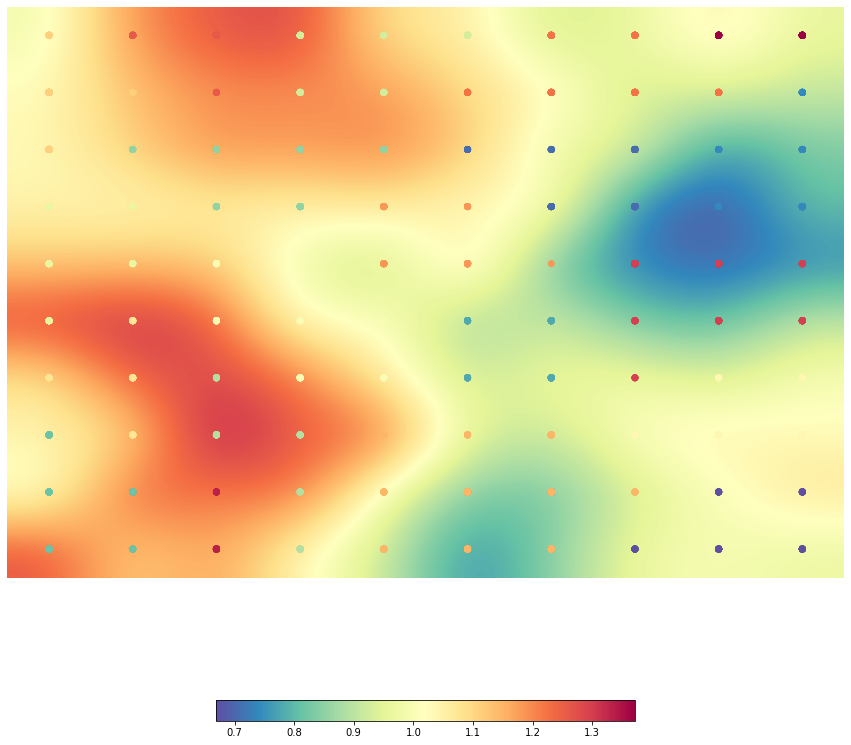

In [ ]:
som.view_umatrix(bestmatches=True, colorbar=True,figsize=(15, 15)) 
matplotlib.pyplot.show()

In [ ]:
print(som.clusters)

[[12 16 16  7  7  7 15 15 19 19]
 [12 12 16  7  7 15 15 15 15  2]
 [12  5  5  5  5  1  1  1  2  2]
 [ 8  8  5  5 14 14  1  1  2  2]
 [ 8  8  9  9 14 14 14 17 17 17]
 [ 8 11  9  9  9  3  3 17 17 17]
 [11 11  6  9  9  3  3 17 10 10]
 [ 4 11  6  6 13 13 13 10 10 10]
 [ 4  4 18  6 13 13 13 13  0  0]
 [ 4  4 18  6 13 13 13  0  0  0]]


In [ ]:
print("Clusters sorted by increasing number of neurons:")
print('Custer Index')
print('Number of Neurons')
neurons, counts = np.unique(som.clusters,return_counts=True)
sorted_counts = np.argsort(counts)
print(list(zip(neurons[sorted_counts], counts[sorted_counts])))

Clusters sorted by increasing number of neurons:
Custer Index
Number of Neurons
[(19, 2), (18, 2), (16, 3), (3, 4), (12, 4), (11, 4), (14, 5), (10, 5), (0, 5), (7, 5), (6, 5), (4, 5), (2, 5), (1, 5), (8, 5), (5, 6), (15, 6), (17, 7), (9, 7), (13, 10)]



## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης του tf-idf, των εμφυτευμάτων και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. 

Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα.

Παράδειγμα εξόδου για ένα cluster (μη βελτιστοποιημένος χάρτης, ωστόσο βλέπετε ότι οι μεγάλες κατηγορίες έχουν σημασιολογική  συνάφεια):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```
   

In [ ]:
def print_categories_stats(movie_ids):

  movie_categories = []

  for movie in movie_ids:
    words = categories[movie].replace('"', '').split(',')
    words = list(map(lambda x: x.strip(), words))
    movie_categories.extend(words)

  cats, counts = np.unique(movie_categories,return_counts=True)
  sorted_counts = np.argsort(counts)[::-1]

  stats = list(zip(cats[sorted_counts], counts[sorted_counts]))
  return stats

In [ ]:
print('Overall category stats:')
print(print_categories_stats(range(150)))

Overall category stats:
[('Drama', 65), ('Comedy', 38), ('Romance Film', 31), ('World cinema', 25), ('Thriller', 23), ('Action', 22), ('Crime Fiction', 22), ('Horror', 16), ('Adventure', 13), ('Action/Adventure', 12), ('Indie', 12), ('Black-and-white', 11), ('Musical', 11), ('Romantic drama', 10), ('Mystery', 9), ('Science Fiction', 8), ('Psychological thriller', 8), ('War film', 7), ('Bollywood', 7), ('Crime Thriller', 7), ('Romantic comedy', 6), ('Fantasy', 6), ('Short Film', 6), ('Silent film', 5), ('Family Film', 5), ('Animation', 5), ('Comedy film', 5), ('Period piece', 5), ('Documentary', 5), ('Japanese Movies', 5), ('Comedy-drama', 5), ('Martial Arts Film', 5), ('Chinese Movies', 4), ('Black comedy', 4), ('B-movie', 4), ('History', 3), ('Teen', 3), ('Cult', 3), ('Suspense', 3), ('Political drama', 3), ('Biography', 3), ('Comedy of Errors', 3), ("Children's/Family", 3), ('Slasher', 3), ('Filipino Movies', 2), ("Children's Fantasy", 2), ('Family Drama', 2), ('Epic', 2), ('Ensemble

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.


In [ ]:
def print_cluster_neurons_report(cluster_n, som = som):

  clusters = np.where(som.clusters == cluster_n)[::-1] #Invert the tuples to get column-row
  coordinates = np.column_stack(clusters)

  neurons = [tuple(cluster) for cluster in coordinates if cluster in unique_bmus]

  return neurons

In [ ]:
print(print_cluster_neurons_report(0))

[(8, 8), (9, 8), (7, 9), (8, 9), (9, 9)]


3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 

In [ ]:
def neuron_movies_report(neurons, som = som):
  indices = []
  for neuron in neurons:
    movies = [index for index, coords in enumerate(som.bmus) if tuple(coords) == neuron]
    indices.extend(movies)

  stats = print_categories_stats(indices)

  return indices, stats

In [ ]:
print(neuron_movies_report(print_cluster_neurons_report(10))[1])

[('Comedy', 75), ('Drama', 75), ('Indie', 23), ('Comedy-drama', 21), ('World cinema', 10), ('Black comedy', 10), ('Black-and-white', 7), ('Ensemble Film', 6), ('Coming of age', 6), ('Thriller', 6), ('Sports', 5), ('Parody', 5), ('Crime Fiction', 4), ('Teen', 4), ('Satire', 4), ('Film adaptation', 4), ('Musical', 3), ('Cult', 3), ('Comedy of manners', 3), ('Family Drama', 3), ('Family Film', 3), ('Fantasy', 3), ('Road movie', 3), ('Period piece', 3), ('Political cinema', 2), ('Buddy film', 2), ('Documentary', 2), ('Biographical film', 2), ('War film', 2), ('Fantasy Comedy', 2), ('Silent film', 2), ('Americana', 2), ('Japanese Movies', 2), ('Adventure', 2), ('Anti-war', 1), ('Animation', 1), ('Comedy of Errors', 1), ('Baseball', 1), ('Biopic [feature]', 1), ('Tragicomedy', 1), ('Surrealism', 1), ('Blaxploitation', 1), ('Addiction Drama', 1), ('Childhood Drama', 1), ('Clay animation', 1), ('Stop motion', 1), ('Comedy film', 1), ('New Hollywood', 1), ('Stoner film', 1), ('Social problem fi


## Πειραματισμός/Βελτιστοποίηση Χάρτη

Θα επαναλάβουμε τα παραπάνω κελιά, με διάφορες τιμές για n_columns, n_rows, n_clusters αλλά και μέγεθος εισόδου. Μετά από πειραματισμούς, καταλήγουμε πως ο καλύτερος χάρτης διαμοργώνεται με μέγεθος 25x25, μέγεθος δεδομένων 2500 γραμμές και 25 k-means clusters. Ο χρόνος εκπαίδευσης ανεβαίνει 90 δεύτερα, οπότε δεν είναι πολύ μεγάλο πλήγμα.

In [ ]:
import time

som2 = somoclu.Somoclu(25, 25, maptype="planar")
start_time = time.time()
som2.train(data=final_set[:2500], epochs=100)
train_time = time.time() - start_time
print(train_time)

94.77202606201172


In [ ]:
from sklearn.cluster import KMeans

alg = KMeans(n_clusters=25, n_init=10)
som2.cluster(algorithm=alg)

In [ ]:
som2 = joblib.load('som2_KMeans.pkl')

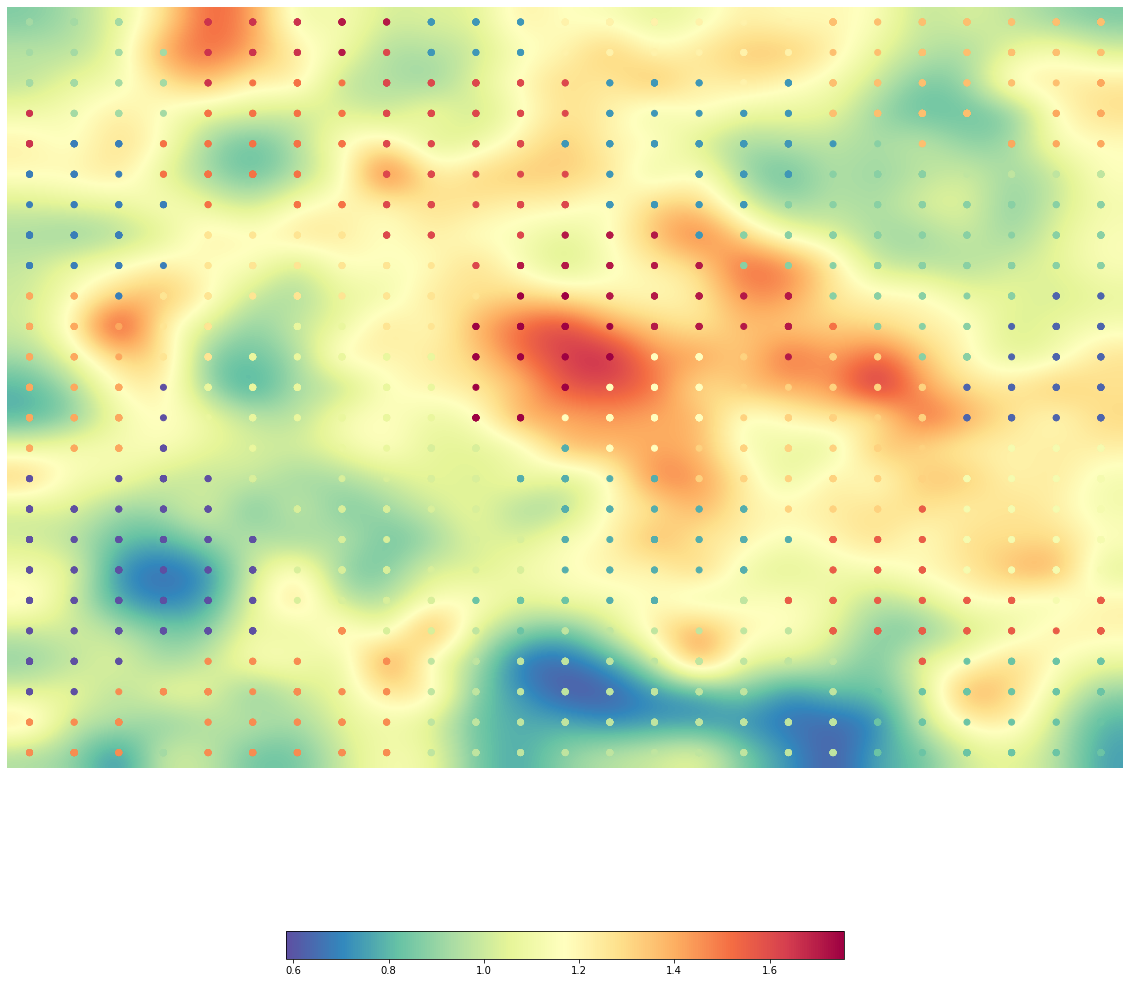

In [ ]:
som2.view_umatrix(bestmatches=True, colorbar=True,figsize=(20, 20)) 
matplotlib.pyplot.show()

In [ ]:
print(som2.clusters)

[[ 7  7  7  7 22 22 22 23 23  3  3  3 13 13 13 13 13 13 16 16 16 16 16 16
  16]
 [ 7  7  7  7 22 22 22 23 21  3  3  3 13 13 13 13 13 13 16 16 16 16 16 16
  16]
 [ 7  7  7  7 22 19 19 19 21 21 21 21 21  3  3  3 13  3 16 16 16 16 16 16
  17]
 [22  7  7  7 19 19 19 19 21 21 21 21 21  3  3  3  3  3 16 16 16 16 16 17
  17]
 [22  2  2 19 19 19 19 19 21 21 21 21  3  3  3  3  3  3  3  6 16 16 17 17
  17]
 [ 2  2  2 19 19 19 19 19 21 21 21 21 21  3  3  3  3  3  6  6  6  8  8  8
   8]
 [ 2  2  2  2 19 19 19 19 21 21 21 21 21  3  3  3  3  6  6  6  6  6  6  6
   6]
 [ 2  2  2  2 14 14 14 14 21 21 21 21 23 23 23  3  6  6  6  6  6  6  6  6
   6]
 [ 2  2  2  2 14 14 14 14 14 14 21 23 23 23 23 23  6  6  6  6  6  6  6  6
   6]
 [17 17  2 14 14 14 14 14 14 14 14 24 24 23 23 23 23 23  6  6  6  6  6  1
   1]
 [17 17 17 14 14 14 10 10 14 14 24 24 24 24 23 23 23 23 19  6  6  6  1  1
   1]
 [17 17 17 14 14 10 10 10 10 10 24 24 24 24 12 12 15 23 15 15  6  6  1  1
   1]
 [17 17 17  0 10 10 10 10 10 10 24 24 24

In [ ]:
joblib.dump(som2, 'som2_KMeans.pkl')

['som2_KMeans.pkl']

Ο χάρτης παρουσίασε μεγάλη βλτίωση μετά την αλλαγή των παραμέτρων. Στα επόμενα ερωτήματα θα προχωρήσουμε χρησιμοποιώντας το μοντέλο som2



## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Μετά το πέρας της εκπαίδευσης και του clustering θα έχετε ένα χάρτη με τοπολογικές ιδιότητες ως προς τα είδη των ταίνιών της συλλογής σας, κάτι αντίστοιχο με την εικόνα στην αρχή της Εφαρμογής 2 αυτού του notebook. Η συγκεκριμένη εικόνα είναι μόνο για εικονογράφιση, δεν είναι χάρτης SOM καιδεν έχει καμία σχέση με τη συλλογή δεδομένων και τις κατηγορίες μας.

Για τον τελικό χάρτη SOM που θα παράξετε για τη συλλογή σας, αναλύστε σε markdown με συγκεκριμένη αναφορά σε αριθμούς clusters και τη σημασιολογική ερμηνεία τους τις εξής τρεις τοπολογικές ιδιότητες του SOM: 

1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.
2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.
3. Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

Προφανώς τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας.

Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.


Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.


### 1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.

In [ ]:
print(print_categories_stats(range(2500)))

[('Drama', 1133), ('Comedy', 609), ('Thriller', 437), ('Romance Film', 391), ('Action', 360), ('World cinema', 292), ('Crime Fiction', 264), ('Horror', 242), ('Action/Adventure', 240), ('Black-and-white', 210), ('Adventure', 209), ('Family Film', 183), ('Indie', 176), ('Short Film', 170), ('Mystery', 154), ('Musical', 153), ('Science Fiction', 135), ('Romantic drama', 126), ('Animation', 117), ('Comedy film', 109), ('War film', 104), ('Fantasy', 103), ('Crime Thriller', 103), ('Romantic comedy', 102), ('Period piece', 87), ('Japanese Movies', 82), ('Bollywood', 67), ('Psychological thriller', 66), ('Western', 65), ('Chinese Movies', 63), ('Documentary', 61), ('Film adaptation', 60), ('Comedy-drama', 60), ('Parody', 59), ('Suspense', 55), ('Silent film', 52), ('Family Drama', 50), ('Black comedy', 47), ('Teen', 47), ("Children's/Family", 46), ('Martial Arts Film', 46), ('Television movie', 45), ('Satire', 44), ('Sports', 43), ('Cult', 42), ('Biographical film', 40), ('Slasher', 38), ('B

Όπως παρατηρούμε, πολυπληθείς είναι οι κατηγορίες Drama, Comedy, Thriller και Romance. Tο μόνο πού έχουμε να βρούμε, είναι ο αριθμός των νευρώνων στους οποίους εμφανίζεται η κάθε κατηγορία.

In [ ]:
movie_categories = []
# For every neuron (25x25), get the categories and them to a list
for i in range(25):
  for j in range(25):
    indices, stats = neuron_movies_report([(i,j)], som = som2)
    movie_categories.extend([cat for cat, count in stats])

# The counts present the number of neurons each category is seen in
cats, counts = np.unique(movie_categories,return_counts=True)
sorted_counts = np.argsort(counts)[::-1]

stats = list(zip(cats[sorted_counts], counts[sorted_counts]))
print(stats)

[('Drama', 293), ('Comedy', 192), ('Thriller', 161), ('Action', 149), ('Romance Film', 130), ('World cinema', 124), ('Crime Fiction', 115), ('Adventure', 108), ('Black-and-white', 106), ('Indie', 103), ('Action/Adventure', 99), ('Horror', 95), ('Musical', 85), ('Family Film', 82), ('Mystery', 78), ('Science Fiction', 77), ('Fantasy', 74), ('War film', 53), ('Comedy film', 52), ('Short Film', 50), ('Period piece', 47), ('Film adaptation', 45), ('Japanese Movies', 44), ('Chinese Movies', 44), ('Crime Thriller', 43), ('Television movie', 42), ('Psychological thriller', 40), ('Sports', 39), ('Teen', 39), ('Animation', 38), ('Western', 36), ('Black comedy', 35), ('Romantic drama', 33), ('Romantic comedy', 33), ('Family Drama', 32), ('Biographical film', 31), ('Satire', 31), ('Bollywood', 29), ('Silent film', 29), ('Comedy-drama', 28), ("Children's/Family", 28), ('Suspense', 28), ('Parody', 27), ('Biography', 26), ('Cult', 26), ('Martial Arts Film', 25), ('History', 25), ('Film noir', 25), (

Έχουμε συνολικά 625 νευρώνες. Η πυκνότητα πιθανότητας κάθε κατηγορίας, τουλάχιστον για τις πιο συχνές, μοιάζει να είναι η ίδια με τον χώρο εισόδου, επιβεβαιώνοντάς μας την π΄΄ρωτη ιδιότητα. Εξαίρεση η κατηφορία Action, της οποίας η πυκνότητα σχεδόν διπλασιάστηκε.

### 2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.

Με την βοήθεια του πίνακα clusters, εντοπίζουμε τα cluster 23, 7 και 8, τα οποία βρίσκονται στα Κεντρικά, ΒΔ και Ν μέρη του SOM, αντίστοιχα.

In [ ]:
neurons = print_cluster_neurons_report(23, som = som2)
print(neuron_movies_report(neurons)[1])

[('Action', 47), ('Adventure', 36), ('Action/Adventure', 27), ('Drama', 21), ('Western', 15), ('Romance Film', 11), ('Comedy', 10), ('Black-and-white', 9), ('Costume drama', 7), ('Crime Fiction', 7), ('Fantasy', 7), ('Thriller', 5), ('Period piece', 5), ('Family Film', 5), ('Film adaptation', 5), ('War film', 4), ('Science Fiction', 4), ('Fantasy Adventure', 4), ('Animation', 3), ('Bollywood', 3), ('Costume Adventure', 3), ('Historical fiction', 3), ('Short Film', 3), ('Swashbuckler films', 3), ('Stop motion', 2), ('Jungle Film', 2), ('Epic', 2), ('History', 2), ('Epic Western', 2), ('Spy', 2), ('Revisionist Western', 2), ('Blaxploitation', 1), ('Comedy Western', 1), ('Combat Films', 1), ('Chinese Movies', 1), ('Superhero movie', 1), ('Biography', 1), ('Suspense', 1), ('Biographical film', 1), ('Airplanes and airports', 1), ('Adventure Comedy', 1), ('Sword and sorcery films', 1), ('Television movie', 1), ('Action Comedy', 1), ('Comedy film', 1), ('Musical', 1), ('Slapstick', 1), ('Film

In [ ]:
neurons = print_cluster_neurons_report(7, som = som2)
print(neuron_movies_report(neurons)[1])

[('Short Film', 71), ('Animation', 69), ('Family Film', 48), ('Comedy', 25), ('Comedy film', 14), ("Children's/Family", 7), ('Musical', 5), ('Animated cartoon', 4), ("Children's", 3), ('Computer Animation', 3), ("Children's Entertainment", 2), ('Thriller', 2), ('Horror', 2), ('Science Fiction', 2), ('Family-Oriented Adventure', 1), ('Sports', 1), ('Domestic Comedy', 1), ('Fantasy', 1), ('Holiday Film', 1), ('Music', 1), ('Propaganda film', 1), ('Romance Film', 1), ('Black-and-white', 1), ('Apocalyptic and post-apocalyptic fiction', 1), ('Anime', 1), ('Experimental film', 1)]


In [ ]:
neurons = print_cluster_neurons_report(8, som = som2)
print(neuron_movies_report(neurons)[1])

[('Drama', 264), ('Comedy', 34), ('Indie', 27), ('Family Film', 19), ('Comedy film', 16), ('Family Drama', 15), ('Black-and-white', 13), ('Biographical film', 13), ('Thriller', 12), ('Comedy-drama', 11), ('Biopic [feature]', 11), ('Musical', 11), ('Romance Film', 8), ('Biography', 8), ('Short Film', 8), ('Sports', 7), ('Television movie', 7), ('Coming of age', 7), ('Period piece', 6), ('Fantasy', 6), ('Silent film', 6), ('Crime Fiction', 5), ('Medical fiction', 5), ('Film adaptation', 5), ('Ensemble Film', 5), ('Horror', 4), ('Melodrama', 4), ('Musical Drama', 4), ('Adventure', 4), ('Courtroom Drama', 3), ('Mystery', 3), ('Chinese Movies', 3), ('Black comedy', 3), ('Historical fiction', 3), ("Children's/Family", 3), ('Christian film', 3), ('Childhood Drama', 2), ('Docudrama', 2), ('Cult', 2), ("Children's", 2), ('World cinema', 2), ('Buddy film', 2), ('Bollywood', 2), ('Teen', 2), ('Slice of life story', 2), ('Science Fiction', 2), ('Satire', 2), ('Romantic comedy', 2), ('Japanese Movi

Παρατηρούμε πως κατα κανόνα οι τρεις συστάδες παρουσιάζουν διαφορετικά είδη ταινιών. Στην 23, βλέπουμε κυρίως ταινίες περιπέτειας, ενώ στην 7 φαίνεται να υπάρχουν οικογενειακές τανίες animation. Τέλος, στην 8 υπάρχουν δράματα.

### 3. Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

Πάνω και δεξιά του χάρτη, βλέπουμε τις συστάδες 6, 8 και 16

In [ ]:
neurons = print_cluster_neurons_report(8, som = som2)
print(neuron_movies_report(neurons)[1])

[('Drama', 264), ('Comedy', 34), ('Indie', 27), ('Family Film', 19), ('Comedy film', 16), ('Family Drama', 15), ('Black-and-white', 13), ('Biographical film', 13), ('Thriller', 12), ('Comedy-drama', 11), ('Biopic [feature]', 11), ('Musical', 11), ('Romance Film', 8), ('Biography', 8), ('Short Film', 8), ('Sports', 7), ('Television movie', 7), ('Coming of age', 7), ('Period piece', 6), ('Fantasy', 6), ('Silent film', 6), ('Crime Fiction', 5), ('Medical fiction', 5), ('Film adaptation', 5), ('Ensemble Film', 5), ('Horror', 4), ('Melodrama', 4), ('Musical Drama', 4), ('Adventure', 4), ('Courtroom Drama', 3), ('Mystery', 3), ('Chinese Movies', 3), ('Black comedy', 3), ('Historical fiction', 3), ("Children's/Family", 3), ('Christian film', 3), ('Childhood Drama', 2), ('Docudrama', 2), ('Cult', 2), ("Children's", 2), ('World cinema', 2), ('Buddy film', 2), ('Bollywood', 2), ('Teen', 2), ('Slice of life story', 2), ('Science Fiction', 2), ('Satire', 2), ('Romantic comedy', 2), ('Japanese Movi

In [ ]:
neurons = print_cluster_neurons_report(6, som = som2)
print(neuron_movies_report(neurons)[1])

[('Drama', 170), ('Comedy', 43), ('Black-and-white', 37), ('Indie', 22), ('Adventure', 18), ('Comedy-drama', 15), ('Crime Fiction', 15), ('Musical', 14), ('Family Drama', 13), ('Period piece', 13), ('Family Film', 11), ('Action/Adventure', 10), ('Coming of age', 9), ('Biographical film', 9), ('Film adaptation', 8), ('History', 8), ('World cinema', 8), ('Black comedy', 7), ('Action', 7), ('War film', 6), ('Western', 6), ('Road movie', 5), ('Silent film', 5), ('Historical fiction', 5), ('Television movie', 5), ('Melodrama', 5), ('Epic', 4), ('Biography', 4), ('Ensemble Film', 4), ('Sports', 4), ('Social problem film', 4), ('Fantasy', 4), ('Biopic [feature]', 4), ('Science Fiction', 4), ('Musical Drama', 3), ('Parody', 3), ('Film noir', 3), ('Romance Film', 3), ('Historical Epic', 3), ('Animal Picture', 3), ("Children's/Family", 3), ('Domestic Comedy', 3), ('Political drama', 3), ('Christian film', 2), ('Addiction Drama', 2), ('Mystery', 2), ('Americana', 2), ('Teen', 2), ('Comedy film', 

In [ ]:
neurons = print_cluster_neurons_report(16, som = som2)
print(neuron_movies_report(neurons)[1])

[('Drama', 135), ('Romance Film', 134), ('Romantic drama', 81), ('Period piece', 25), ('World cinema', 22), ('Film adaptation', 19), ('Black-and-white', 18), ('War film', 12), ('Melodrama', 12), ('Musical', 11), ('Indie', 8), ('Costume drama', 6), ('Fantasy', 6), ('Comedy film', 6), ('Comedy', 5), ('Western', 5), ('Adventure', 5), ('Thriller', 5), ('Romantic comedy', 4), ('Biographical film', 4), ('Action/Adventure', 4), ('Epic', 4), ('Crime Fiction', 4), ('Family Film', 4), ('Biography', 4), ('Teen', 3), ('Musical Drama', 3), ('Dance', 3), ('History', 3), ('Biopic [feature]', 3), ('Pre-Code', 3), ('Television movie', 3), ('Chinese Movies', 2), ('Coming of age', 2), ('Comedy-drama', 2), ('Family Drama', 2), ('Action', 2), ('Roadshow theatrical release', 2), ('Romantic fantasy', 2), ('Historical fiction', 2), ('Marriage Drama', 2), ('Sports', 2), ('Medical fiction', 2), ('Backstage Musical', 1), ('Boxing', 1), ('Short Film', 1), ('Silent film', 1), ('Feminist Film', 1), ('Buddy film', 1

Όντως, είναι πολύ κοντά μεταξύ τους, Όλες αποτελούν διαφορετικά είδη δραμάτων. Για παράδειγμα, στην 8 έχουμε οικογενειακές ταινίες-δράματα, στην 6 απρόμαυρα, indie δράματα, και στην 16 φαίνεται να βρίσκονται ρομαντικά δράματα.

### Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.

Σχολιάζουμε τις συστάδες 18, 19 και 21

In [ ]:
neurons = print_cluster_neurons_report(18, som = som2)
print(neuron_movies_report(neurons)[1])

[('Short Film', 42), ('Comedy film', 22), ('Romance Film', 17), ('Black-and-white', 14), ('Silent film', 14), ('Musical', 11), ('Indie', 10), ('Japanese Movies', 10), ('Documentary', 8), ('Family Film', 7), ('Chinese Movies', 6), ('Culture & Society', 5), ('Horror', 5), ('Biography', 4), ('Thriller', 3), ('Crime Fiction', 3), ('Adventure', 3), ('Sports', 3), ('Dance', 2), ('Science Fiction', 2), ('Animation', 2), ('Anime', 2), ('Drama', 2), ('Black comedy', 2), ('Romantic comedy', 2), ('Comedy', 2), ('Romantic drama', 2), ('Fantasy', 2), ('Christian film', 1), ('Social issues', 1), ('Political drama', 1), ('Superhero movie', 1), ("Children's", 1), ('Crime Thriller', 1), ('Surrealism', 1), ('Teen', 1), ('B-movie', 1), ('Avant-garde', 1), ('Animated cartoon', 1), ('Blaxploitation', 1), ('Domestic Comedy', 1), ('Slice of life story', 1), ('Rockumentary', 1), ('Propaganda film', 1), ('Music', 1), ('Mockumentary', 1), ('Melodrama', 1), ('Psychological thriller', 1), ('Interpersonal Relation

In [ ]:
neurons = print_cluster_neurons_report(19, som = som2)
print(neuron_movies_report(neurons)[1])

[('Black-and-white', 15), ('Western', 9), ('Japanese Movies', 9), ('Thriller', 8), ('Silent film', 8), ('Musical', 6), ('Action/Adventure', 5), ('Crime Fiction', 5), ('Film noir', 4), ('Adventure', 4), ('Science Fiction', 4), ('Pre-Code', 3), ('Anime', 3), ('Indie', 3), ('Action', 3), ('War film', 3), ('Filipino Movies', 2), ('Romantic comedy', 2), ('Music', 2), ('Sports', 2), ('Spy', 2), ('Fantasy', 2), ('Documentary', 2), ('Teen', 1), ('Christian film', 1), ("Children's/Family", 1), ("Children's Entertainment", 1), ('Propaganda film', 1), ('Black comedy', 1), ('Television movie', 1), ('Comedy-drama', 1), ('Tokusatsu', 1), ('Addiction Drama', 1), ('Comedy film', 1), ('Sword and sorcery', 1), ('Computer Animation', 1), ('Costume drama', 1), ('Crime Drama', 1), ('Psychological thriller', 1), ('Disaster', 1), ('Dystopia', 1), ('Erotic thriller', 1), ('Family Film', 1), ('Foreign legion', 1), ('Horror', 1), ('Short Film', 1), ('Zombie Film', 1)]


In [ ]:
neurons = print_cluster_neurons_report(21, som = som2)
print(neuron_movies_report(neurons)[1])

[('Thriller', 22), ('Romance Film', 21), ('Action', 16), ('Comedy film', 10), ('World cinema', 7), ('Mystery', 7), ('Horror', 6), ('Chinese Movies', 6), ('Drama', 5), ('Musical', 5), ('Fantasy', 4), ('Comedy', 4), ('Bollywood', 3), ('Crime Fiction', 3), ('Science Fiction', 3), ('Western', 3), ('Adventure', 3), ('War film', 2), ('Martial Arts Film', 2), ('Family Film', 2), ('Silent film', 2), ('Biographical film', 1), ('Crime', 1), ("Children's/Family", 1), ('Black-and-white', 1), ('Detective', 1), ('Action/Adventure', 1), ('Doomsday film', 1), ('Fairy tale', 1), ('Erotic thriller', 1), ('Blaxploitation', 1), ('Crime Thriller', 1), ('Wuxia', 1), ('Film noir', 1), ('Gangster Film', 1), ('Tollywood', 1), ('Time travel', 1), ('Tamil cinema', 1), ('Sword and sorcery', 1), ('Short Film', 1), ('Romantic drama', 1), ('Romantic comedy', 1), ('Psychological thriller', 1), ('Political thriller', 1), ('Musical comedy', 1), ('Musical Drama', 1), ('Music', 1), ('Melodrama', 1), ('Japanese Movies', 1

Οι συστάδες δεν παρουσιάζουν σε πλειοψηφία κάποια κατηγορία. Ή, έστω, δεν παρουσιάζουν συναφείς μεταξύ τους κατηγορίες στις πιο πολυπληθείς. Στην 18, υπάρχουν πάρα πολλές κατηγορίες που εμφανίζονται 10+ φορές η καθεμία, χωρίς να είναι σχετικές μεταξύ τους. Στις 19 και 22, οι οποίες βρίσκονται δίπλα η μια στην άλλη, όμως δεν είναι συναφείς, ξανά εμφανίζονται λίγες κατηγορίες με μεγάλη συχνότητα, όμως οι συνδυασμοί των κατηγοριών δεν φαίνεται να είναι έγκυροι.

In [ ]:
neurons = print_cluster_neurons_report(3, som = som2)
print(neuron_movies_report(neurons)[1])

[('Drama', 96), ('World cinema', 18), ('Comedy', 16), ('Romance Film', 14), ('Action', 14), ('Thriller', 14), ('Family Film', 11), ('Crime Fiction', 10), ('Japanese Movies', 10), ('Family Drama', 7), ('Period piece', 7), ('Mystery', 7), ('Bollywood', 5), ('Indie', 5), ('Adventure', 4), ('Biographical film', 4), ('Black-and-white', 4), ('Chinese Movies', 4), ('Comedy film', 4), ('Musical', 4), ('Television movie', 4), ('Sports', 3), ('Art film', 3), ('Biography', 3), ('Horror', 3), ('Romantic drama', 3), ('Comedy-drama', 3), ('Political drama', 2), ('Documentary', 2), ('Action/Adventure', 2), ('Biopic [feature]', 2), ('Silent film', 2), ('Culture & Society', 2), ('Romantic comedy', 2), ('Western', 2), ('Teen', 2), ('War film', 1), ('Satire', 1), ('Action Comedy', 1), ('Language & Literature', 1), ('Kitchen sink realism', 1), ('Psychological thriller', 1), ('Spaghetti Western', 1), ('Revisionist Western', 1), ('Film adaptation', 1), ('Black comedy', 1), ('Family-Oriented Adventure', 1), 

Επίσης, βλέπουμε το μικρό cluster 3, το οποίο, πέραν των δραμάτων, παρουσιάζει πολλές κατηγορίες με περισσότερες από 10 εμφανίσεις, οι οποίες δεν είναι απαραίτητα σχετικές. Αυτό μπορεί να συμβαίνει γιατί το 3 βρίσκεται σε μια ενδιάμση περιοχή, και επηρεάζεται από πολλες γύρω συστάδες με διαφορες δευτερέυουσες κατηγορίες

### Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.

Ενδιαφέρον παρουσιάζει το cluster 0, το οποίο φαίνετια να έχει συσσωρεύσει τις ταινίες που υπάγονται στην κατηγορία της κωμωδίας. Θα μπορούσαμε να πούμε πως η συσσώρευση ήταν αναμενόμενη, αφου μιλάμε για μπλε περιοχή

In [ ]:
neurons = print_cluster_neurons_report(0, som = som2)
print(neuron_movies_report(neurons)[1])

[('Comedy', 188), ('Black-and-white', 37), ('Parody', 30), ('Short Film', 26), ('Satire', 19), ('Indie', 18), ('Slapstick', 17), ('Musical', 16), ('Black comedy', 13), ('Cult', 12), ('Family Film', 10), ('Sex comedy', 10), ('World cinema', 8), ('Adventure', 8), ('Science Fiction', 7), ('Crime Fiction', 6), ('Absurdism', 6), ('Silent film', 6), ('Teen', 6), ('Action/Adventure', 5), ('Romance Film', 5), ('Comedy film', 4), ('Sports', 4), ('Media Satire', 4), ('Comedy-drama', 4), ('Action', 4), ('Comedy of Errors', 3), ('Fantasy', 3), ('Ensemble Film', 3), ('Thriller', 3), ('Chinese Movies', 3), ('Domestic Comedy', 3), ('Horror', 3), ("Children's/Family", 3), ('Screwball comedy', 3), ('Crime Comedy', 3), ('Mystery', 3), ('Animation', 2), ('Political cinema', 2), ('Workplace Comedy', 2), ('Disaster', 2), ('Coming of age', 2), ('Drama', 2), ('Religious Film', 2), ('Family Drama', 2), ('Western', 2), ('Horror Comedy', 2), ('Comedy Western', 2), ('War film', 2), ('Gross out', 2), ('Gross-out 

Άλλη μια μπλε περιοχή, είναι της συστάδας 8, όπου όντως βλέπουμε την μεγαλύτερη συχνότητα δραμάτων.

In [ ]:
neurons = print_cluster_neurons_report(8, som = som2)
print(neuron_movies_report(neurons)[1])

[('Drama', 264), ('Comedy', 34), ('Indie', 27), ('Family Film', 19), ('Comedy film', 16), ('Family Drama', 15), ('Black-and-white', 13), ('Biographical film', 13), ('Thriller', 12), ('Comedy-drama', 11), ('Biopic [feature]', 11), ('Musical', 11), ('Romance Film', 8), ('Biography', 8), ('Short Film', 8), ('Sports', 7), ('Television movie', 7), ('Coming of age', 7), ('Period piece', 6), ('Fantasy', 6), ('Silent film', 6), ('Crime Fiction', 5), ('Medical fiction', 5), ('Film adaptation', 5), ('Ensemble Film', 5), ('Horror', 4), ('Melodrama', 4), ('Musical Drama', 4), ('Adventure', 4), ('Courtroom Drama', 3), ('Mystery', 3), ('Chinese Movies', 3), ('Black comedy', 3), ('Historical fiction', 3), ("Children's/Family", 3), ('Christian film', 3), ('Childhood Drama', 2), ('Docudrama', 2), ('Cult', 2), ("Children's", 2), ('World cinema', 2), ('Buddy film', 2), ('Bollywood', 2), ('Teen', 2), ('Slice of life story', 2), ('Science Fiction', 2), ('Satire', 2), ('Romantic comedy', 2), ('Japanese Movi